In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('classic')
import matplotlib.colors as mpl_colors
from matplotlib import cm as cmx
from matplotlib.ticker import FormatStrFormatter
from numpy.lib.recfunctions import append_fields
from cloudyfsps import outObj as ob
from HIImodels import modObj,altBPT,pxl_plot,nColors,getColors, get_contours, plot_2Dhist
from UVplotting import(redden, deredden, wind_arrow, plot_sench_ratio,
                       plot_reddening_vector, plot_reddening_single, line_logZ_plot,
                       make_inset, make_logZ_plot, ratio_ratio, redden_ratio)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('font',size=16,family='serif',
       serif=[r'cmr10'],style='normal',
       variant='normal',stretch='normal')#,weight='heavy')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [2]:
import HIImodels
reload(HIImodels)

<module 'HIImodels' from 'HIImodels.pyc'>

In [3]:
import sys
sys.path.append('/astro/users/ebyler/python/mangst/mangst/')
import lineinds

In [4]:
ls -ltr /astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines

-rw-rw-r-- 1 ebyler ebyler 3207989 Dec  3 18:30 /astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines


In [5]:
ls -ltr /astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines

-rw-rw-r-- 1 ebyler ebyler 3207989 Dec  3 18:31 /astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines


In [6]:
linefile='/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(linefile)
zau.gas_logZ = zau.logZ + 12. + -3.31
###
blinefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
bst = modObj(blinefile)
bst.gas_logZ = bst.logZ + 12. + -3.31
###
uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

i = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            i += 1
            float_lambda = float(u[1])
            if float_lambda < 3900.0:
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam

print i
zau.add_lines(ulined)
bst.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    nkey_arr = np.log10(bst.__getattribute__(line)/bst.Hb)
    #line_arr = np.log10(zau.__getattribute__(line))
    line_arr = zau.__getattribute__(line)
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)
    #
    line_arr = bst.__getattribute__(line)
    bst.__setattr__(nkey, nkey_arr)
    bst.__setattr__(line, line_arr)
av_logz = -0.5
av_logu = -2.5
av_age = 4.e6
av_ind = int(np.nonzero((zau.logZ == av_logz) &
                        (zau.logU == av_logu) &
                        (zau.age == av_age))[0])
bav_ind = int(np.nonzero((bst.logZ == av_logz) &
                         (bst.logU == av_logu) &
                         (bst.age == av_age))[0])

321


In [7]:
def get_berg_info():
    dir_='/astro/users/ebyler/research/uvem'
    return np.genfromtxt(dir_+'/data/berg_BNCD1.dat', names=True, dtype=None, delimiter=',')

def get_berg_data(ew=False):
    dir_='/astro/users/ebyler/research/uvem'
    if ew:
        bdata = np.genfromtxt(dir_+'/data/berg_ews.dat', names=True, dtype=None, delimiter=',')
    else:
        bdata = np.genfromtxt(dir_+'/data/berg_BNCDall.dat', names=True, dtype=None, delimiter=',')
    gdata = get_berg_info()
    gals = [d[0] for d in gdata]
    return gals, bdata, gdata

def get_berg_em(line):
    '''
    returns array(line_1/Hb, line_2/Hb...line_n/Hb), array(line_1_err, line_2_err, ...)
    '''
    gals, bdata, gdata = get_berg_data()
    ed = dict(CIV_1548=0, CIV_1551=1, HeII_1640=2,
              OIII_1660=3, OIII_1666=4, SiIII_1883=5,
              SiIII_1892=6, CIII_1906=7, CIII_1908=8,
              OII_3727=9, NeIII_3869=10, OIII_4363=13,
              Hb=14, OIII_4958=15, OIII_5007=16,
              NII_6548=17, Ha=18, NII_6583=19, SII_6716=20, SII_6730=21)
    arr = np.array([float(bdata[gal][ed[line]]) for gal in gals])
    err = np.array([float(bdata[gal+'_e'][ed[line]]) for gal in gals])
    return arr, err

def get_berg_ew(line, return_z=False):
    '''
    returns array(line_1/Hb, line_2/Hb...line_n/Hb), array(line_1_err, line_2_err, ...)
    '''
    gals, edata, gdata = get_berg_data(ew=True)
    
    #gals = ['J082555','J104457','J120122','J124159', 'J122622','J122436', 'J124827']
    ed = dict(CIV_1548=0, CIV_1551=1, HeII_1640=2,
              OIII_1660=3, OIII_1666=4, SiIII_1883=5,
              SiIII_1892=6, CIII_1906=7, CIII_1908=8)
    if line == 'CIII_doublet':
        arr = np.array([float(edata[gal][7])+float(edata[gal][8]) for gal in gals])
    else:
        arr = np.array([float(edata[gal][ed[line]]) for gal in gals])
    if return_z:
        zarr = []
        for gal in gals:
            ind, = np.where(gal == gdata['Target'])
            zarr.append(gdata['log_O'][int(ind)])
        return arr, np.array(zarr)
    else:
        return arr

def calc_berg_ratio(lines, return_z=False):
    #gals = ['J082555','J104457','J120122','J124159', 'J122622','J122436', 'J124827']
    top, bot = lines[0], lines[1]
    t_arr, t_err = get_berg_em(top)
    b_arr, b_err = get_berg_em(bot)
    if bot == 'Hb' or bot == 'hb':
        ratio = np.log10(t_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
    else:
        ratio = np.log10(t_arr/b_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
    if return_z:
        gals, bdata, galdat = get_berg_data()
        zarr = []
        for gal in gals:
            ind, = np.where(gal == galdat['Target'])
            zarr.append(galdat['log_O'][int(ind)])
        return ratio, error, np.array(zarr)
    else:
        return ratio, error

def plot_berg_ratio(xratio, yratio, ax=None, plot_lines=False,
                    marker='o', markersize=5,
                    color='grey', mec='None', ecolor='grey',
                    zorder=-1, alpha=1.0):
    try:
        xdata, xerr = calc_berg_ratio(xratio)
    except KeyError:
        return None
    try:
        ydata, yerr = calc_berg_ratio(yratio)
    except KeyError:
        return None
    if plot_lines:
        for x,y,xe,ye in zip(xdata, ydata, xerr, yerr):
            if np.isfinite(x) & np.isfinite(y):
                print '1 ', x, y
                ax.errorbar(x, y, xerr=xe, yerr=ye, capsize=0,
                            marker=marker, markersize=markersize,
                            color=color, ecolor=ecolor, mec=mec,
                            zorder=zorder, ls='None')
            elif np.isfinite(y):
                # there is no x ratio >> horizontal line
                print '2 ', x, y
                ax.axhline(y, color='k', lw=0.75)
                ax.axhspan(y-ye, y+ye, color='k', alpha=0.15)
            elif np.isfinite(x):
                # no y ratio >> vertical line
                print '3 ', x, y
                ax.axvline(x, color='k', lw=0.75)
                ax.axvspan(x-xe, x+xe, color=color, alpha=0.15)
    else:
        ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr,
                    marker=marker, markersize=markersize,
                    color=color, ecolor=ecolor, mec=mec,
                    capsize=0, zorder=zorder, ls='None')
    return

def plot_berg_data_z_ratio(yratio, ax=None):
    ydata, yerr, zarr = calc_berg_ratio(yratio, return_z=True)
    ax.errorbar(zarr, ydata, yerr=yerr,
                fmt='o', capsize=0, color='k', markeredgecolor='None', ecolor='black')
    return



In [8]:
def get_sench_data():
    dir_='/astro/users/ebyler/research/uvem'
    data = np.genfromtxt(dir_+'/data/Senchyna.dat', names=True, dtype=None, delimiter=',')
    gals = [b[0] for b in data]
    return gals, data

def get_sench_em(line):
    gals, data = get_sench_data()
    arr = data[line]
    err = data[line+'_e']
    return arr, err

def calc_sench_ratio(lines, return_z=False):
    top, bot = lines[0], lines[1]
    t_arr, t_err = get_sench_em(top)
    b_arr, b_err = get_sench_em(bot)
    if bot == 'Hb' or bot == 'hb':
        ratio = np.log10(t_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
    else:
        ratio = np.log10(t_arr/b_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
        error[(t_err < 0.0) & (b_err >= 0.0)] = -99.99
        error[(b_err < 0.0) & (t_err >= 0.0)] = 99.99
        error[(t_err < 0.0) & (b_err < 0.0)] = np.nan
    if return_z:
        return ratio, error, bdata['log_O']
    else:
        return ratio, error

def plot_sench_ratio(xratio, yratio, ax=None, plot_lims=True,
                     color='grey', zorder=5, marker='D',
                     markersize=5, mec='None', ecolor='grey'):
    try:
        xdata0, xerr0 = calc_sench_ratio(xratio)
    except(KeyError, ValueError):
        return None
    try:
        ydata0, yerr0 = calc_sench_ratio(yratio)
    except(KeyError, ValueError):
        return None
    inds = [i for i in range(len(xdata0)) if (np.isfinite(xerr0[i]) & np.isfinite(yerr0[i]))]
    xdata, xerr = xdata0[inds], xerr0[inds]
    ydata, yerr = ydata0[inds], yerr0[inds]
    if plot_lims:
        goodx = (xerr != -99.99) & (xerr != 99.99)
        goody = (yerr != -99.99) & (yerr != 99.99)
        ax.errorbar(xdata[goodx & goody], ydata[goodx & goody],
                    xerr=xerr[goodx & goody], yerr=yerr[goodx & goody], capsize=0,
                    marker=marker, markersize=markersize,  ls='None',
                    color=color, ecolor=ecolor, mec=mec, zorder=zorder)
        for x,y,xe,ye in zip(xdata, ydata, xerr, yerr):
            if xe == -99.99:
                ax.errorbar(x, y, xerr=0.1, xlolims=True, ls='None',
                            marker=marker, markersize=markersize,
                            color=color, ecolor=ecolor, mec=mec, zorder=zorder)
            if xe == 99.99:
                ax.errorbar(x, y, xerr=0.1, xuplims=True, ls='None',
                            marker=marker, markersize=markersize,
                            color=color, ecolor=ecolor, mec=mec, zorder=zorder)
            if ye == -99.99:
                ax.errorbar(x, y, yerr=0.1, lolims=True, ls='None',
                            marker=marker, markersize=markersize,
                            color=color, ecolor=ecolor, mec=mec, zorder=zorder)
            if ye == 99.99:
                ax.errorbar(x, y, yerr=0.1, uplims=True, ls='None',
                            marker=marker, markersize=markersize,
                            color=color, ecolor=ecolor, mec=mec, zorder=zorder)
    else:
        ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, capsize=0, ls='None',
                    marker=marker, markersize=markersize,
                    color=color, ecolor=ecolor, mec=mec, zorder=zorder)
    return
def get_senchyna_ews(line='CIII', return_log=True):
    dd = dict(CIII='CIII_1907_1909', OIII='OIII_1666', HeII='HeII_1640')
    dir_='/astro/users/ebyler/research/uvem'
    data = np.genfromtxt(dir_+'/data/Senchyna_ew_data.dat', names=True, dtype=None, delimiter=',')
    if line in dd.keys():
        if return_log:
            v = np.log10(data[dd[line]])
            err = np.log10(data[dd[line]]+data[dd[line]+'_err']) - v
            return v, err
        else:
            return data[dd[line]], data[dd[line]+'_err']
    else:
        if return_log:
            v = np.log10(data[line])
            err = np.log10(data[line]+data[line+'_err']) - v
            return v, err
        else:
            return data[line], data[line+'_err']

def get_lit_ews(line='CIII', return_log=True):
    '''
    log_O
    CIII
    CIII_err
    OIII_5007
    OIII_5007_err
    O32
    OIII_5007_Hb
    '''
    dir_='/astro/users/ebyler/research/uvem'
    data = np.genfromtxt(dir_+'/data/Senchyna_lit_data.dat', names=True, dtype=None, delimiter=',')
    srcs = np.array([dat['Name'].split('_')[-1].strip('(').strip(')') for dat in data])
    if return_log:
        v = np.log10(data[line])
        if line+'_err' in data.dtype.names:
            err = np.log10(data[line]+data[line+'_err']) - v
            return v, err, srcs
        else:
            return v, srcs
    else:
        if line+'_err' in data.dtype.names:
            return data[line], data[line+'_err'], srcs
        else:
            return data[line], srcs

In [9]:
ratio_names =  ['log_SiIII_1883_CIII_1906',
                'log_CIV_1551_OIII_1666', 
                'log_CIV_1548_OIII_1666',
                'log_OIII_1666_CIII_1906',
                'log_NeIII_3869_OII_3727',
                'log_OIII_5007_OII_3727', 
                'log_HeII_1640_Hb']
ratio_labels =  ['$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1907 )',
                 '$\\log_{10}$( CIV$\\;\\lambda$1551 / OIII$\\;\\lambda$1666 )', 
                 '$\\log_{10}$( CIV$\\;\\lambda$1548 / OIII$\\;\\lambda$1666 )',
                 '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )',
                 '$\\log_{10}$( NeIII$\\;\\lambda$3870 / OII$\\;\\lambda$3727 )',
                 '$\\log_{10}$( OIII$\\;\\lambda$5007 / OII$\\;\\lambda$3727 )', 
                 '$\\log_{10}$( HeII$\\;\\lambda$1640 / H$\\beta$ )']
 
ratio_lines =  [('SiIII_1883', 'CIII_1906'),
                ('CIV_1551', 'OIII_1666'),
                ('CIV_1548', 'OIII_1666'),
                ('OIII_1666', 'CIII_1906'),
                ('NeIII_3869', 'OII_3727'),
                ('OIII_5007', 'OII_3727'),
                ('HeII_1640', 'Hb')]

# Fig. 14

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10


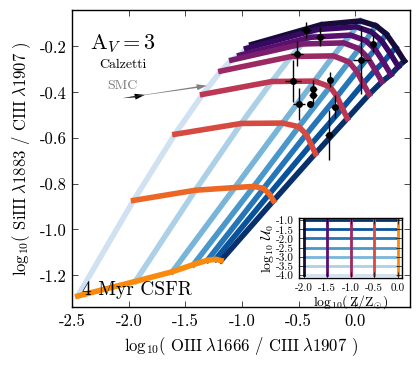

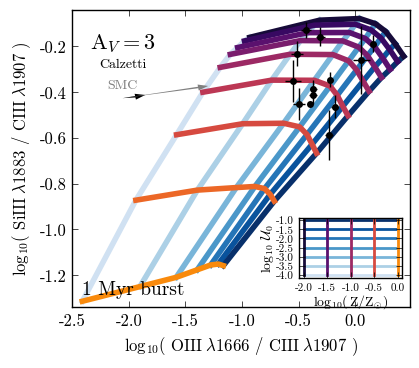

In [10]:
xi, yi = 3, 0
xname, xlab, xratio = ratio_names[xi], ratio_labels[xi], ratio_lines[xi]
yname, ylab, yratio = ratio_names[yi], ratio_labels[yi], ratio_lines[yi]
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=4.e6, av_ind=av_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)

xlims, ylims = ax.get_xlim(), ax.get_ylim()
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.savefig('../figs/f14b.pdf')
fig.savefig('../figs/f14b.png')
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(bst, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=bav_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
##
ax.set_xlim(xlims)
ax.set_ylim(ylims)
##
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.savefig('../figs/f14a.pdf')
fig.savefig('../figs/f14a.png')

# Fig.15

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10


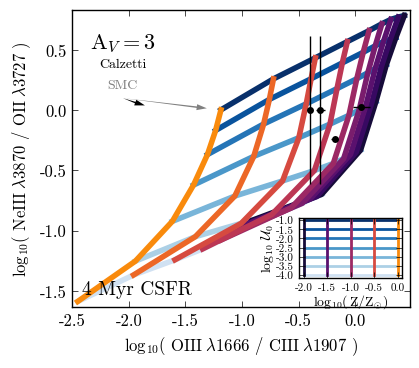

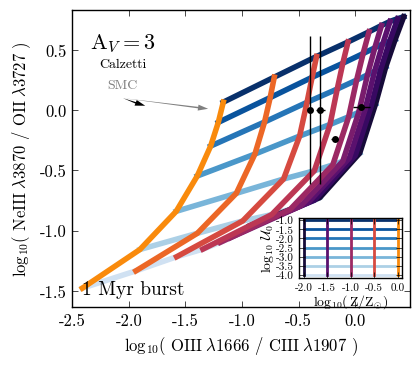

In [11]:
xi, yi = 3, 4
xname, xlab, xratio = ratio_names[xi], ratio_labels[xi], ratio_lines[xi]
yname, ylab, yratio = ratio_names[yi], ratio_labels[yi], ratio_lines[yi]
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=4.e6, av_ind=av_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
xlims, ylims = ax.get_xlim(), ax.get_ylim()
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.savefig('../figs/f15b.pdf')
fig.savefig('../figs/f15b.png')
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(bst, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.7, age=1.e6, av_ind=bav_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.03),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='bottom')
fig.savefig('../figs/f15a.pdf')
fig.savefig('../figs/f15a.png')

# Fig.16

### 16 (a,b)

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10
/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


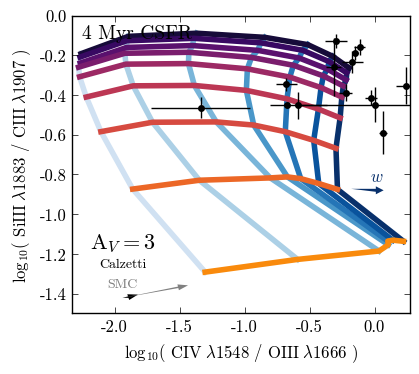

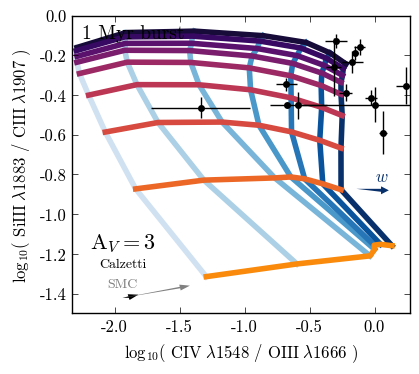

In [12]:
xi, yi = 2, 0
xname, xlab, xratio = ratio_names[xi], ratio_labels[xi], ratio_lines[xi]
yname, ylab, yratio = ratio_names[yi], ratio_labels[yi], ratio_lines[yi]
#####
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)

##
xlims, ylims = ax.get_xlim(), ax.get_ylim()
ylims=(-1.5,0.0)
ax.set_xlim(xlims)
ax.set_ylim(ylims)
###
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top', zorder=10)
wind_arrow(-0.18, -0.88, ax=ax, dx=0.25, dy=0.0, label=r'$w$',
           xshift=-5, yshift=10, width=0.015, head_width=0.04)
plot_sench_ratio(xratio, yratio, ax=ax)
fig.savefig('../figs/f16b.pdf')
fig.savefig('../figs/f16b.png')
######
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(bst, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=1.0e6, av_ind=bav_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
##
ax.set_xlim(xlims)
ax.set_ylim(ylims)
##
wind_arrow(-0.14, -0.88, ax=ax, dx=0.25, dy=0.0, label=r'$w$',
           xshift=-5, yshift=10, width=0.015, head_width=0.04)
plot_sench_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
##
ax.annotate('1 Myr burst', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top', zorder=10)
fig.savefig('../figs/f16a.pdf')
fig.savefig('../figs/f16a.png')

### Fig. 16 c,d

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10
/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10


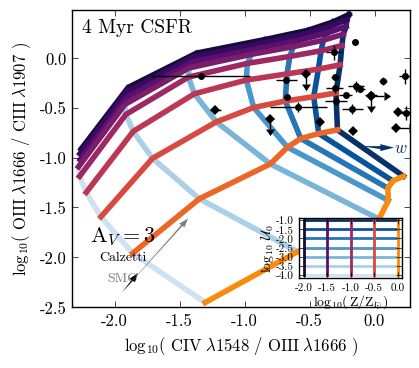

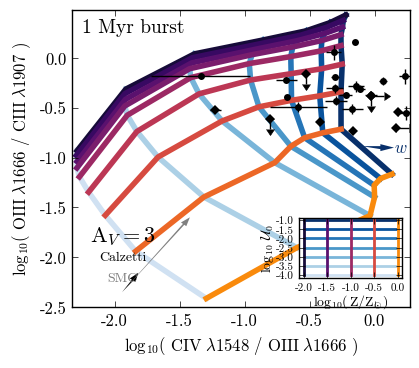

In [13]:
xi, yi = 3, 2
yname, ylab, yratio = ratio_names[xi], ratio_labels[xi], ratio_lines[xi]
xname, xlab, xratio = ratio_names[yi], ratio_labels[yi], ratio_lines[yi]
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
plot_sench_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)

##
wind_arrow(-0.1, -0.9, ax=ax, dx=0.25, dy=0.0, label=r'$w$',
           xshift=5, yshift=0, width=0.03, head_width=0.07)
##
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
fig.savefig('../figs/f16d.pdf')
fig.savefig('../figs/f16d.png')

xlims, ylims = ax.get_xlim(), ax.get_ylim()
#--------------------------------------------
fig, ax = plt.subplots(1, figsize=(4.5,4))
ratio_ratio(bst, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=1.e6, av_ind=bav_ind)
plot_berg_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)
plot_sench_ratio(xratio, yratio, ax=ax, color='k', ecolor='k', zorder=7)

ax.set_xlim(xlims)
ax.set_ylim(ylims)
##
wind_arrow(-0.1, -0.9, ax=ax, dx=0.25, dy=0.0, label=r'$w$',
           xshift=5, yshift=0, width=0.03, head_width=0.07)
##
make_inset(axlims=[.7, .27, .23, .15], pad=0)
ax.annotate('1 Myr burst', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
fig.savefig('../figs/f16c.pdf')
fig.savefig('../figs/f16c.png')

In [14]:
import pickle
from numpy.lib import recfunctions

samplefile = open('/astro/users/ebyler/research/newem/SNcuts_kappa20_sample.pickle', 'rb')
sample = pickle.load(samplefile)
samplefile.close()
# add fields to recarr
sample = recfunctions.append_fields(sample, ['log_OIII_Hb','log_SII_Ha', 'O32', 'nlR23'],
                                    [np.log10(sample['OIII5007']/sample['Hbeta']),
                                     np.log10((sample['SII6717']+sample['SII6731'])/sample['Halpha']),
                                     10.**sample['OIII/OII'],
                                     10.**sample['logR23']],
                                    asrecarray=True)

In [15]:
def getModelEWs(logZ=-0.5, logU=-1.0, age=4.0, line='Ha',
                return_time=False, logt=True,
                dir_='/astro/users/ebyler/research/uvem/data/AbsEmData/'):
    '''
    line = 'Ha','OIII_5007', 'CIII_1906','CIII_1909'
    returns the 11 Leitherer absorption line indices
    for the specified parameters
    ages, logQHs, logQHes, EWs = getModelEWs(return_Q=True)
    '''
    dir_='/astro/store/scratch/tmp/ebyler/AbsEmData/'
    if logZ < 0.0:
        logZstr = 'm{0:02.0f}'.format(np.abs(logZ)*10)
    else:
        logZstr = 'p{0:02.0f}'.format(np.abs(logZ)*10)
    logUstr = 'logU_{0:.1f}'.format(logU*-1)
    flname = '{}EmEw_{}_{}_EW.dat'.format(dir_, logZstr, logUstr)
    try:
        data = np.genfromtxt(flname, delimiter=',', names=True, dtype=None)
    except:
        print '{} does not exist'.format(flname.split('/')[-1])
        return np.full(1, np.nan)
    agesMyr = (10.**data['age'])/1.e6
    if return_time:
        if logt:
            outage = data['age']
        else:
            outage = agesMyr
        return outage, data[line]
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        return data[age_ind][line]

In [16]:
getModelEWs(logZ=0.0, logU=-1.0, return_time=True)

(array([  5.  ,   5.05,   5.1 ,   5.15,   5.2 ,   5.25,   5.3 ,   5.35,
          5.4 ,   5.45,   5.5 ,   5.55,   5.6 ,   5.65,   5.7 ,   5.75,
          5.8 ,   5.85,   5.9 ,   5.95,   6.  ,   6.05,   6.1 ,   6.15,
          6.2 ,   6.25,   6.3 ,   6.35,   6.4 ,   6.45,   6.5 ,   6.55,
          6.6 ,   6.65,   6.7 ,   6.75,   6.8 ,   6.85,   6.9 ,   6.95,
          7.  ,   7.05,   7.1 ,   7.15,   7.2 ,   7.25,   7.3 ,   7.35,
          7.4 ,   7.45,   7.5 ,   7.55,   7.6 ,   7.65,   7.7 ,   7.75,
          7.8 ,   7.85,   7.9 ,   7.95,   8.  ,   8.05,   8.1 ,   8.15,
          8.2 ,   8.25,   8.3 ,   8.35,   8.4 ,   8.45,   8.5 ,   8.55,
          8.6 ,   8.65,   8.7 ,   8.75,   8.8 ,   8.85,   8.9 ,   8.95,
          9.  ,   9.05,   9.1 ,   9.15,   9.2 ,   9.25,   9.3 ,   9.35,
          9.4 ,   9.45,   9.5 ,   9.55,   9.6 ,   9.65,   9.7 ,   9.75,
          9.8 ,   9.85,   9.9 ,   9.95,  10.  ,  10.05,  10.1 ,  10.15,
         10.2 ,  10.25,  10.3 ]),
 array([  6.06965300e+03,   6.

In [17]:
sfh='burst'
if sfh=='burst':
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
else:
    fname = '/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(fname)

uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

#uvdat = np.genfromtxt('./local_emLines.dat', delimiter='\t', dtype=None)
#ulines = []
#ulined = {}
i=0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            float_lambda = float(u[1])
            if (float_lambda < 3900.0) & (float_lambda > 1220.):
                i += 1
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
zau.add_lines(ulined)

In [18]:
zau.nlR23 = 10.**zau.R23
zau.O32 = 10.**zau.log_OIII_OII
zau.gas_logZ = zau.logZ + 12. + -3.31

ulined['OIII_5007']=5006.8
ulined['Hb']=4861.0
ulined['hb']=4861.0
ulined['Ha']=6562.0
ulined['ha']=6562.0
ulined['OIII_2'] = np.mean([5007.,4959.])
ulined['OII_2'] = np.mean([3727., 3729.])
ulined['NII_2'] = 6584.
zau.OIII_5007 = zau.OIIIb
zau.OIII_2 = zau.OIIIa + zau.OIIIb
zau.OII_2 = zau.OII_3727 + zau.OII_3729
zau.NII_2 = zau.NIIb
#bst.OIII_5007 = bst.OIIIb
zau.hb = zau.Hb
#bst.hb = bst.Hb

av_logz = -0.5
av_logu = -2.5
av_age = 4.e6
av_ind = int(np.nonzero((zau.logZ == av_logz) &
                        (zau.logU == av_logu) &
                        (zau.age == av_age))[0])

In [19]:
logZs = [-2.0, -1.75, -1.5, -1.25, -1.0, -0.75, -0.5, -0.25, 0.0, 0.25, 0.5]
#logZs = [-2.0, -1.5, -1.0, -0.5, 0.0, 0.5]
logUs = [-4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0]
ages = zau.age_vals[1::]
CIII_1906_EWs = np.ones_like(zau.age)
CIII_doublet_EWs = np.ones_like(zau.age)
OIII_5007_EWs = np.ones_like(zau.age)
for i in range(zau.nmods):
    if (zau.logZ[i] in logZs) & (zau.age[i] in ages) & (zau.logU[i] in logUs):
        EW = getModelEWs(logZ=zau.logZ[i], logU=zau.logU[i], line='CIII_1906',
                         age=zau.age[i]/1.e6)
        CIII_1906_EWs[i] *= EW
        EW2 = getModelEWs(logZ=zau.logZ[i], logU=zau.logU[i], line='CIII_1909',
                          age=zau.age[i]/1.e6)
        CIII_doublet_EWs[i] *= EW+EW2
        EW = getModelEWs(logZ=zau.logZ[i], logU=zau.logU[i], line='OIII_5007',
                         age=zau.age[i]/1.e6)
        OIII_5007_EWs[i] *= EW
    else:
        CIII_1906_EWs[i] = np.nan
        OIII_5007_EWs[i] = np.nan
        CIII_doublet_EWs[i] = np.nan
zau.__setattr__('CIII_1906_EW', CIII_1906_EWs)
zau.__setattr__('CIII_doublet_EW', CIII_doublet_EWs)
zau.__setattr__('OIII_5007_EW', OIII_5007_EWs)

# Fig. 17: CIII EWs as a function of metallicity

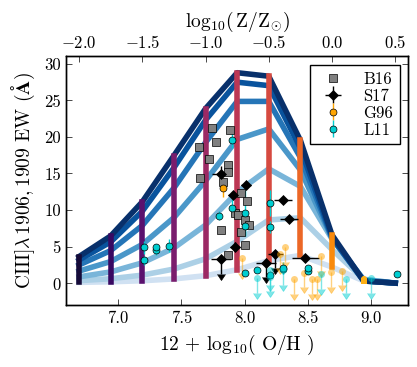

In [20]:
fig, ax = plt.subplots(1, figsize=(4.5,4))

yname = 'CIII_doublet_EW'
ylab = r'CIII]$\lambda\,1906,1909$ EW ($\mathrm{\AA}$)'
line_logZ_plot(zau, yname=yname, ylab=ylab, ax=ax, age=2.e6, zlims=(-2.0, 0.5),
               desired_tick_locations=np.array([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5]))

#####
x, xerr = get_senchyna_ews(line='log_O', return_log=False)
y, yerr = get_senchyna_ews(line='CIII', return_log=False)
inds = (yerr != -99.99)
ax.errorbar(x[inds], y[inds], xerr=xerr[inds], yerr=yerr[inds],
            ls='None', color='k', capsize=0, marker='D',
            zorder=9, markersize=5, label='S17')
ax.errorbar(x[~inds], y[~inds], xerr=xerr[~inds], yerr=2.0, uplims=True,
            ls='None', color='k', capsize=0, marker='D', zorder=9, markersize=5)
####
x, src = get_lit_ews(line='log_O', return_log=False)
y, yerr, src = get_lit_ews(line='CIII', return_log=False)
colors, syms = ['grey','orange', 'darkturquoise'], ['s','o','o']
for lab, col, sym in zip(np.unique(src), colors, syms):
    if lab == 'B16':
        continue
    sinds = (src == lab)
    xx, yy, yyerr = x[sinds], y[sinds], yerr[sinds]
    inds = (yyerr != -99.99)
    ax.errorbar(xx[inds], yy[inds], yerr=yyerr[inds],
                ls='None', color=col, capsize=0, mec='k',
                marker=sym, zorder=9, markersize=5, label=lab)
    ax.errorbar(xx[~inds], yy[~inds], yerr=2.0, uplims=True,
                ls='None', color=col, capsize=0, mec='None',
                marker=sym, zorder=9, markersize=5, alpha=0.5)
##
ydata, zarr = get_berg_ew('CIII_doublet', return_z=True)
ax.plot(zarr, ydata,
        marker='s', ls='None', color='grey', zorder=9, markeredgecolor='k', label='B16')
#
ax.legend(loc=0, numpoints=1, fontsize=12)
ax.set_ylim(-3, 31)
fig.tight_layout()
fig.savefig('../figs/f17.pdf')
fig.savefig('../figs/f17.png')

# Fig.18: optical diagrams with CIII EW color

### Fig.18 (a) BPT with CIII EW

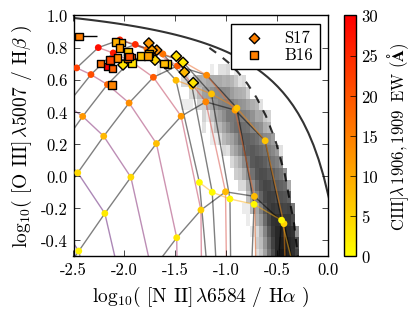

In [21]:
fig, ax = plt.subplots(1, figsize=(4.5,3.5))
#fig, ax = plt.subplots(1, figsize=(4.5,4))
xlab=r'$\log_{10}$( [N II]$\,\lambda$6584 / H$\alpha$ )'
ylab=r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )'
# ------------------------------------------------------
sMc, cNorm = getColors(np.linspace(0,30), cname='autumn_r', minv=0.0, maxv=1.0, return_cNorm=True)
# ------------------------------------------------------
####
# SDSS data
####
sxname = 'logNHa'
syname = 'log_OIII_Hb'
xlim=[-1.7, 0.1]
ylim=[-2.4, 1.2]
plot_2Dhist(sample[sxname], sample[syname], ranges=[[-2.0,0.0], ylim], ax=ax,
            cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
# add lines
NII = np.linspace(-4.5, 0.04)
OIII = 0.61/(NII - 0.05) + 1.3
ax.plot(NII[NII >= -1.25], OIII[NII >= -1.25], '--', color='k', lw=1.5, alpha=0.8)
NII = np.linspace(-4.5, 0.46, 100)
OIII = 0.61/(NII - 0.47) + 1.19
ax.plot(NII, OIII, color='k', lw=1.5, alpha=0.8)
######
ax.set_xlabel(xlab, size=14)
ax.set_ylabel(ylab, size=14)
#ax.set_xlim(-2.3, 0.3)
#ax.set_ylim(-2.2, 1.2)
xlim, ylim = (-2.5, 0.0), (-0.5, 1.0)
# ---------------------------------------------
# plot model grid
#
age=1.e6
xname, yname='log_NIIb_Ha','log_OIIIb_Hb'
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
# grid
altBPT(zau, ax=ax, age=age,
       xname=xname, yname=yname,
       xclims=(-4.0, -1.0), xlim=xlim, ylim=ylim,
       yclims=(-2.0,0.5),
       **return_cdict(1.0, alpha=0.5, cname='binary', lw=1))
####
# color by CIII EW
inds = (zau.logZ <= 0.5) & (zau.logZ >= -2.0) & (zau.age == age)
######
######
plt.scatter(zau.log_NIIb_Ha[inds], zau.log_OIIIb_Hb[inds],
            c=zau.CIII_doublet_EW[inds], s=24, edgecolor='None', cmap=sMc.cmap, norm=cNorm, zorder=3)
cb = plt.colorbar()
cb.set_label(r'CIII]$\lambda\,1906,1909\,$ EW ($\mathrm{\AA}$)', fontsize=12)
cb.set_ticks([0, 5, 10, 15, 20, 25, 30])
#####
# Senchyna data
#####
x, xerr = get_senchyna_ews(line='NII_Ha')
y, yerr = get_senchyna_ews(line='OIII_Hb')
c, cerr = get_senchyna_ews(line='CIII', return_log=False)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, ls='None', color='k', capsize=0, zorder=9)
ax.scatter(x,y,c=c, marker='D', cmap=sMc.cmap, norm=cNorm, s=28, zorder=10, label='S17')
####
# Berg data
####
x, xerr = calc_berg_ratio(('NII_6583', 'Ha'))
y, yerr = calc_berg_ratio(('OIII_5007', 'Hb'))
ce = get_berg_ew('CIII_doublet')
ax.errorbar(x, y, xerr=xerr, yerr=yerr, ls='None', color='k', capsize=0, zorder=9)
ax.scatter(x,y,c=ce, marker='s', cmap=sMc.cmap, norm=cNorm, s=28, zorder=10, label='B16')
####
leg = ax.legend(loc=0, scatterpoints=1, fontsize=12)
leg.legendHandles[0].set_color(plt.cm.autumn(0.5))
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(plt.cm.autumn(0.5))
leg.legendHandles[1].set_edgecolor('k')
fig.tight_layout()
fig.savefig('../figs/f18a.pdf')
fig.savefig('../figs/f18a.png')

### Fig.18 (b) : O32 vs R23 with CIII EW

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:59: RuntimeWarning: invalid value encountered in log10


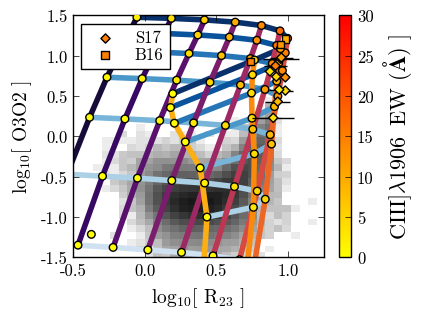

In [22]:
fig, ax = plt.subplots(1, figsize=(4.5,3.5))

# -------------------
sMc, cNorm = getColors(np.linspace(0,30), cname='autumn_r', minv=0.0, maxv=1.0, return_cNorm=True)

sxname = 'logR23'
syname = 'OIII/OII' 
ylim= [-2.2, 2.0]#1.75]
xlim=[-1.5, 1.5]

#sxname = 'nlR23'
#syname = 'O32' 
#ylim= [0.0, 15]
#xlim=[0.0, 10]

#xlim=[-1.7, 0.1]
#ylim=[-2.4, 1.2]
#xlab=r'$\log_{10}$( [N II]$\,\lambda$6584 / H$\alpha$ )'
#ylab=r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )'
#### plotting
plot_2Dhist(sample[sxname], sample[syname], ranges=[xlim, ylim],
            ax=ax, cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)

# -----------
age=1.e6
xname, yname='R23','log_OIII_OII'

altBPT(zau, ax=ax, age=age,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.0,0.25))
inds = (zau.logZ <= 0.5) & (zau.logZ >= -2.0) & (zau.age == age)
plt.scatter(zau.R23[inds], zau.log_OIII_OII[inds],s=30,
            c=zau.CIII_1906_EW[inds], cmap=sMc.cmap, norm=cNorm, edgecolor='k', zorder=4)
#####
x, xerr = get_senchyna_ews(line='R23')
y, yerr = get_senchyna_ews(line='O32')
c, cerr = get_senchyna_ews(line='CIII', return_log=False)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, ls='None', color='k', capsize=0, zorder=5)
plt.scatter(x,y,c=c, marker='D', cmap=sMc.cmap, norm=cNorm, s=22, zorder=10, label='S17')
####
cb = plt.colorbar()
cb.set_label(r'CIII]$\lambda1906\,$ EW ($\mathrm{\AA}$) ]')
cb.set_ticks([0, 5, 10, 15, 20, 25, 30])
plt.xlim(-0.5, 1.25)
plt.ylim(-1.5, 1.5)
####
#x, xerr = calc_ratio(('NII_6583', 'Ha'))
#y, yerr = calc_ratio(('OIII_5007', 'Hb'))
#c = get_ew('CIII_doublet')
#ax.errorbar(x, y, xerr=xerr, yerr=yerr, ls='None', color='k', capsize=0, zorder=9)
#ax.scatter(x,y,c=c, marker='s', cmap=sMc.cmap, norm=cNorm, s=28, zorder=10, label='B16')
####
a, g = calc_berg_ratio(('OII_3727', 'Hb'))
b, g = calc_berg_ratio(('OIII_4958','Hb'))
c, g = calc_berg_ratio(('OIII_5007', 'Hb'))
e = get_berg_ew(line='CIII_doublet')

R23 = np.log10(10.**a + 10.**b + 10.**c)
O32 = np.log10((10.**b + 10.**c)/10.**a)
plt.scatter(R23, O32, c=e, marker='s', s=28, label='B16', zorder=6, cmap=sMc.cmap, norm=cNorm)
##


ax.set_xlabel(r'$\log_{10}$[ R$_{23}$ ]', size=14)
ax.set_ylabel(r'$\log_{10}$[ O3O2 ]', size=14)

leg = ax.legend(loc=2, scatterpoints=1, fontsize=12)
leg.legendHandles[0].set_color(plt.cm.autumn(0.5))
leg.legendHandles[0].set_edgecolor('k')
leg.legendHandles[1].set_color(plt.cm.autumn(0.5))
leg.legendHandles[1].set_edgecolor('k')



fig.tight_layout()
fig.savefig('../figs/f18b.pdf')
fig.savefig('../figs/f18b.png')

### Fig.18 (c) : CIII EW vs OIII EW

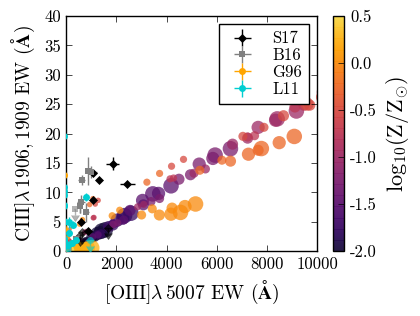

In [23]:
fig, ax = plt.subplots(1, figsize=(4.5,3.5))
age=1.e6
inds = (zau.logZ <= 0.5) & (zau.logZ >= -2.0) & (zau.age <= 2.e6)#& (zau.age == age)
sMz, zNorm = getColors(np.linspace(-2.0, 0.5), cname='inferno', minv=0.1, maxv=0.9, return_cNorm=True)
#plt.scatter(zau.OIII_5007_EW[inds], zau.CIII_doublet_EW[inds],
#            c=zau.age[inds]/1.e6, s=(zau.logU[inds]+8)*3, marker='o', edgecolor='None', cmap='coolwarm')
aa = plt.scatter(zau.OIII_5007_EW[inds], zau.CIII_doublet_EW[inds],
            c=zau.logZ[inds], s=(zau.logU[inds]+6)**3, marker='o', alpha=0.75,
                 edgecolor='None', cmap=sMz.cmap, norm=zNorm)
#####
x, xerr = get_senchyna_ews(line='OIII_5007', return_log=False)
y, yerr = get_senchyna_ews(line='CIII', return_log=False)
inds = (yerr != -99.99)
ax.errorbar(x[inds], y[inds], xerr=xerr[inds], yerr=yerr[inds],
            ls='None', color='k', capsize=0, marker='D',
            zorder=9, markersize=4, label='S17')
ax.errorbar(x[~inds], y[~inds], xerr=xerr[~inds], yerr=1.0, uplims=True, alpha=0.6,
            ls='None', color='k', capsize=0, marker='D', zorder=9, markersize=4)
###
x, xerr, src = get_lit_ews(line='OIII_5007', return_log=False)
y, yerr, src = get_lit_ews(line='CIII', return_log=False)
colors, syms = ['green','orange', 'blue'], ['s','*','o']
colors, syms = ['grey','orange', 'darkturquoise'], ['s','o','o']
for lab, col, sym in zip(np.unique(src), colors, syms):
    sinds = (src == lab)
    xx, yy, yyerr, xxerr = x[sinds], y[sinds], yerr[sinds], xerr[sinds]
    inds = (yyerr != -99.99)
    ax.errorbar(xx[inds], yy[inds], yerr=yyerr[inds], xerr=xxerr[inds],
                ls='None', color=col, capsize=0, mec='None',
                marker=sym, zorder=9, markersize=5, label=lab)
    ax.errorbar(xx[~inds], yy[~inds], xerr=xxerr[~inds], yerr=1.0, uplims=True,
                ls='None', color=col, capsize=0, mec='None',
                marker=sym, zorder=9, markersize=5, alpha=0.6)
#
cb = plt.colorbar(aa)
#cb.set_label('Age (Myr)', fontsize=12)
#cb.set_ticks([1,2,3,4,5,6])
cb.set_ticks([-2, -1.5, -1.0, -0.5, 0.0, 0.5])
cb.set_label(r'$\log_{10}$(Z/Z$_{\odot}$)')
plt.legend(loc=0, numpoints=1, fontsize=12)
###
ax.set_xlim(0.0, 10000.0)
ax.set_xticks([0,2000,4000, 6000, 8000, 10000])
ax.set_ylim(0.0, 40.0)
ax.set_xlabel(r'[OIII]$\lambda\,5007$ EW ($\mathrm{\AA}$)', size=14)
ax.set_ylabel(r'CIII]$\lambda\,1906,1909$ EW ($\mathrm{\AA}$)', size=14)
fig.tight_layout()
fig.savefig('../figs/f18c.pdf')
fig.savefig('../figs/f18c.png')

In [24]:
dir_='/astro/users/ebyler/research/uvem/data'
Zfl = dir_+'/BCDs/Zs.dat'
zdata = np.genfromtxt(Zfl, names=True, dtype=None, delimiter=',')
EWfl = dir_+'/BCDs/EWs.dat'
EWfl = dir_+'/BCDs/EWs_err.dat'
ewdata = np.genfromtxt(EWfl, names=True, dtype=None, delimiter=',')
tdata = np.genfromtxt(dir_+'/BCDs/Zetterlund_Tab2.dat', dtype=None, names=True, delimiter=',')

KK04 = []
O3N2 = []
N2 = []
altName = []
z = []
TEW = []
TEWerr = []
for dat in ewdata:
    name = dat['GalName']
    ind= np.where(zdata['ID'] == name)
    i = ind[0]
    if len(i) > 0:
        KK04.append(zdata['KK04'][i][0])
        O3N2.append(zdata['O3N2'][i][0])
        N2.append(zdata['N2'][i][0])
        altName.append(zdata['GalaxyName'][i][0])
        z.append(zdata['z'][i][0])
        TEW.append(tdata[i]['CIV_1550'][0])
        TEWerr.append(tdata[i]['CIV_1550_err'][0])
    else:
        KK04.append(-99.)
        O3N2.append(-99.)
        N2.append(-99.)
        altName.append('X')
        z.append(-99.)
        TEW.append(-99.)
        TEWerr.append(-99.)
BCDs = append_fields(ewdata,
                     ['KK04', 'O3N2', 'N2', 'altName', 'z', 'TEW', 'TEWerr'],
                     [np.array(KK04), np.array(O3N2), np.array(N2), np.array(altName), np.array(z), np.array(TEW), np.array(TEWerr)],
                     usemask=False)

In [25]:
dir_='/astro/users/ebyler/research/uvem/data'
linefile=dir_+'/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(linefile)
zau.gas_logZ = zau.logZ + 12. + -3.31
uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}
i = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            i += 1
            float_lambda = float(u[1])
            if float_lambda < 3900.0:
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
print i
zau.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    #line_arr = np.log10(zau.__getattribute__(line))
    line_arr = zau.__getattribute__(line)
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)

321


In [26]:
def grab_absLines(logZ=0.0, age=4.0, logU=-2.0, return_time=False, line_index=5,
                  isochrone='mist', sfh='csfr', lineset='L', logt=False):
    '''
    returns the 11 Leitherer absorption line indices for the specified parameters
    '''
    #logZs = [-1.0, -0.5, 0.0, 0.5]
    #if logZ not in logZs:
    #    return np.full(11, np.nan)
    dir_='/astro/users/ebyler/research/uvem/data'
    Zstr = 'm{0:02.0f}'.format(np.abs(logZ)*10) if logZ < 0.0 else 'p{0:02.0f}'.format(np.abs(logZ)*10)
    Ustr = '{0:.1f}'.format(logU*-1)
    fname = dir_+'/AbsEmData/logU_{}_{}_{}_{}_EW_{}.dat'.format(Ustr,
                                                                isochrone,
                                                                sfh,
                                                                lineset,
                                                                Zstr)
    try:
        data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    except:
        #print '{} does not exist'.format(fname.split('/')[-1])
        return np.full(11, np.nan)
    
    data = np.genfromtxt(fname, delimiter=',', unpack=True, dtype=None)
    agesMyr = (10.**data[0])/1.e6
    if return_time:
        if logt:
            outage = data[0]
        else:
            outage = agesMyr
        return (outage, data[1::][line_index])
    else:
        age_ind = np.argmin(np.abs(agesMyr - age))
        return data[1::, age_ind]

In [27]:
zau.EWs = np.full((zau.nmods, 11), 0.0)
for logZ in zau.logZ_vals:
    for age in zau.age_vals:
        for logU in zau.logU_vals:
            modind, = np.where((zau.logZ == logZ) & (zau.age == age) & (zau.logU == logU))
            ind = int(modind)
            zau.EWs[ind] = grab_absLines(logZ=logZ, age=age/1.e6, logU=logU)
# create a few absorption line attributes for testing
zau.abs_CIV = zau.EWs[:,4]
zau.abs_MgII = zau.EWs[:,10]
zau.abs_AlII = zau.EWs[:,6]
zau.abs_AlIII = zau.EWs[:,7]
zau.abs_FeII = zau.EWs[:,5]
zau.abs_SiIV = zau.EWs[:,2]

#
flname = dir_+'/UVabs.dat'
data = np.genfromtxt(flname, skip_header=1, names=True, dtype=None, delimiter=',', unpack=True)
index = [dat['Index'] for dat in data]
bandpass = [[float(a) for a in dat['Bandpass'].split('-')] for dat in data]
rcont = [[float(a) for a in dat['RedCont'].split('-')] for dat in data]
bcont = [[float(a) for a in dat['BlueCont'].split('-')] for dat in data]
nindex = len(index)

# Fig.19

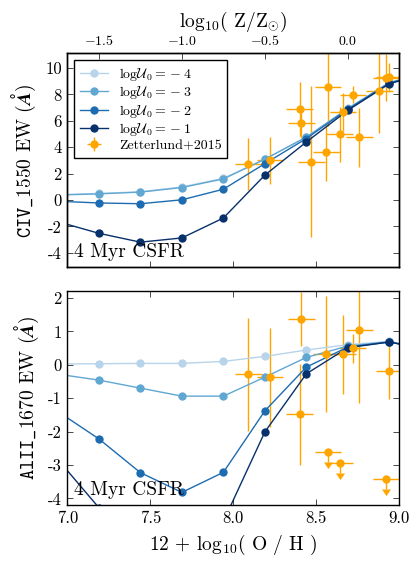

In [28]:
fig, axes = plt.subplots(2, figsize=(4.5,6))

ax = fig.axes[0]
yname = 'CIV_1550'
inds = (BCDs['KK04'] > 0.0)
#ax.errorbar(BCDs['O3N2'][inds], BCDs[yname][inds], yerr=BCDs[yname+'_err'][inds]*0.1, fmt='o',
#            color='Orange', markeredgecolor='None', label='Zetterlund+2015 (O3N2)',
#            ecolor='orange', capsize=0)
ax.errorbar(BCDs['KK04'][inds], BCDs['TEW'][inds], yerr=BCDs['TEW'+'err'][inds], xerr=0.08, fmt='o',
            color='orange', markeredgecolor='None', label='Zetterlund+2015',
            ecolor='orange', capsize=0)
ax.set_xticklabels([''])
ax.set_ylim(-5.1, 11.1)
binds = np.isnan(zau.abs_CIV)
sM = getColors(zau.logU_vals, cname='Blues', minv=0.3, maxv=1.0)
for u in [-4.0, -3.0, -2.0, -1.0]:
    civ_arr = zau.abs_CIV[~binds & (zau.age == 4.e6) & (zau.logU == u)]
    z_arr = zau.gas_logZ[~binds & (zau.age == 4.e6) & (zau.logU == u)]
    srt = np.argsort(z_arr)
    ax.plot(z_arr[srt], civ_arr[srt], '-o',
            color=sM.to_rgba(u), markeredgecolor='None',
            label=r'log$\mathcal{{U}}_0 = {0:.0f}$'.format(u))
ax.set_ylabel(r'$\tt{CIV\_1550}$ EW ($\AA$)', size=14)
ax.legend(numpoints=1, fontsize=10, loc=0)
ax.annotate(r'4 Myr CSFR', xy=(0.02, 0.03), xycoords='axes fraction',
            ha='left', va='bottom', size=14)

###
#ax.set_xlim(7.15, 9.25)
ax.set_xlim(7.0, 9.0)
ax2 = ax.twiny()
ax2.set_xlabel(r'$\log_{10}$( Z/Z$_{\odot} )$', size=14)
desired_tick_locations = np.array([-1.5, -1.0, -0.5, 0.0])
def tick_function(X):
    V = X + 12.0 + -3.31
    return V
tick_locations = tick_function(desired_tick_locations)
def tick_labels(V):
    return [r"${0:.1f}$".format(z) for z in V]
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(tick_locations)
ax2.set_xticklabels(tick_labels(desired_tick_locations), size=10)
###
ax = fig.axes[1]
yname = 'AlII_1670'
inds = (BCDs['KK04'] > 0.0) & (BCDs[yname] > -4.0)
binds = (BCDs[yname][inds] <= -2.0)
#ax.plot(BCDs['O3N2'][inds], BCDs[yname][inds], 'o',
#        color='Orange', markeredgecolor='None', label='Zetterlund+2015 (O3N2)')
ax.errorbar(BCDs['KK04'][inds][~binds], BCDs[yname][inds][~binds],
            yerr=BCDs[yname+'_err'][inds][~binds]*0.12, xerr=0.08, fmt='o',
            color='orange', markeredgecolor='None', label='Zetterlund+2015',
            ecolor='orange', capsize=0)
ax.errorbar(BCDs['KK04'][inds][binds], BCDs[yname][inds][binds],
            yerr=0.3, uplims=True, xerr=0.08, fmt='o',
            color='orange', markeredgecolor='None', label='Z15',
            ecolor='orange', capsize=0)

binds = np.isnan(zau.abs_SiIV)
for u in [-4.0, -3.0, -2.0, -1.0]:
    al_arr = zau.abs_AlII[~binds & (zau.age == 4.e6) & (zau.logU == u)]
    z_arr = zau.gas_logZ[~binds & (zau.age == 4.e6) & (zau.logU == u)]
    srt = np.argsort(z_arr)
    ax.plot(z_arr[srt], al_arr[srt], '-o',
            color=sM.to_rgba(u), markeredgecolor='None',
            label=r'log$\mathcal{{U}}_0 = {0:.0f}$'.format(u))
ax.set_xlabel(r'12 + $\log_{10}$( O / H )', size=14)
ax.set_ylabel(r'$\tt{AlII\_1670}$ EW ($\AA$)', size=14)
#ax.legend(numpoints=1, fontsize=10, loc=0)
ax.annotate(r'4 Myr CSFR', xy=(0.02, 0.03), xycoords='axes fraction',
            ha='left', va='bottom', size=14)
ax.set_ylim(-4.2, 2.2)
ax.set_xlim(7.0, 9.0)

plt.tight_layout()

fig.savefig('../figs/f19.pdf')
fig.savefig('../figs/f19.png')

In [29]:
linefile='/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(linefile)
zau.gas_logZ = zau.logZ + 12. + -3.31
###
blinefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
bst = modObj(blinefile)
bst.gas_logZ = bst.logZ + 12. + -3.31
###
uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

i = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            i += 1
            float_lambda = float(u[1])
            if float_lambda < 3900.0:
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam

print i
zau.add_lines(ulined)
bst.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    nkey_arr = np.log10(bst.__getattribute__(line)/bst.Hb)
    #line_arr = np.log10(zau.__getattribute__(line))
    line_arr = zau.__getattribute__(line)
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)
    #
    line_arr = bst.__getattribute__(line)
    bst.__setattr__(nkey, nkey_arr)
    bst.__setattr__(line, line_arr)
av_logz = -0.5
av_logu = -2.5
av_age = 4.e6
av_ind = int(np.nonzero((zau.logZ == av_logz) &
                        (zau.logU == av_logu) &
                        (zau.age == av_age))[0])
bav_ind = int(np.nonzero((bst.logZ == av_logz) &
                         (bst.logU == av_logu) &
                         (bst.age == av_age))[0])

321


In [30]:
def read_stark(line):
    dir_='/astro/users/ebyler/research/uvem/data'
    data = np.genfromtxt(dir_+'/Stark2014.dat', names=True, dtype=None, delimiter=',')
    gals = data.dtype.names[2::2]
    ed = dict(N_V=0, N_IV=1, CIV_1548=2, HeII_1640=3,
              OIII_1660=4, OIII_1666=5, NIII_1752=6, SiIII_1883=7)
    if line == 'log_O':
        return np.array([float(data[gal][-1]) for gal in gals])
    else:
        arr = np.array([float(data[gal][ed[line]]) for gal in gals])
        err = np.array([float(data[gal+'_e'][ed[line]]) for gal in gals])
        return arr, err

def stark_ratio(lines):
    top, bot = lines[0], lines[1]
    t_arr, t_err = read_stark(top)
    if bot == 'CIII_1906':
        b_arr, b_err = np.ones_like(t_arr), np.zeros_like(t_err)
        ratio = np.log10(t_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
    else:
        b_arr, b_err = read_stark(bot)
        ratio = np.log10(t_arr/b_arr)
        error = ((t_err/(t_arr*np.log(10)))**2.0 + (b_err/(b_arr*np.log(10)))**2.0)**0.5
    error[(t_err < 0.0) & (b_err >= 0.0)] = -99.99 # maximum value it can be, an upper limit
    error[(b_err < 0.0) & (t_err >= 0.0)] = 99.99 # value can only get larger, a lower limit
    error[(t_err < 0.0) & (b_err < 0.0)] = np.nan
    error[(t_arr == -99.99)] = np.nan
    error[(b_arr == -99.99)] = np.nan
    return ratio, error

def plot_stark_ratio(xratio, yratio, ax=None, plot_lims=True, yscale=0.05, xscale=0.05, zorder=3):
    xdata0, xerr0 = stark_ratio(xratio)
    ydata0, yerr0 = stark_ratio(yratio)
    inds = [i for i in range(len(xdata0)) if (np.isfinite(xerr0[i]) & np.isfinite(yerr0[i]))]
    xdata, xerr = xdata0[inds], xerr0[inds]
    ydata, yerr = ydata0[inds], yerr0[inds]
    if plot_lims:
        yv = (ax.get_ylim()[1] - ax.get_ylim()[0])*yscale
        xv = (ax.get_xlim()[1] - ax.get_xlim()[0])*xscale
        goodx = (xerr != -99.99) & (xerr != 99.99)
        goody = (yerr != -99.99) & (yerr != 99.99)
        ax.errorbar(xdata[goodx & goody], ydata[goodx & goody],
                    xerr=xerr[goodx & goody], yerr=yerr[goodx & goody],
                    fmt='o', capsize=0, color='k', zorder=zorder)
        for x,y,xe,ye in zip(xdata, ydata, xerr, yerr):
            if xe == -99.99:
                ax.errorbar(x, y, xerr=xv, xuplims=True, fmt='o', color='k', zorder=zorder)
            if xe == 99.99:
                ax.errorbar(x, y, xerr=xv, xlolims=True, fmt='o', color='k', zorder=zorder)
            if ye == -99.99:
                ax.errorbar(x, y, yerr=yv, uplims=True, fmt='o', color='k', zorder=zorder)
            if ye == 99.99:
                ax.errorbar(x, y, yerr=yv, lolims=True, fmt='o', color='k', zorder=zorder)
    else:
        ax.errorbar(xdata, ydata, xerr=xerr, yerr=yerr, fmt='o', capsize=0, color='k', zorder=zorder)
    return

def plot_stark_z_ratio(yratio, ax=None, plot_lims=True, yscale=0.05):
    ydata0, yerr0= stark_ratio(yratio)
    zarr0 = read_stark('log_O')
    inds = [i for i in range(len(ydata0)) if np.isfinite(yerr0[i])]
    ydata, yerr, zarr = ydata0[inds], yerr0[inds], zarr0[inds]
    if plot_lims:
        yv = (ax.get_ylim()[1] - ax.get_ylim()[0])*yscale
        goody = (yerr != -99.99) & (yerr != 99.99)
        ax.errorbar(zarr[goody], ydata[goody],
                    yerr=yerr[goody], fmt='o', capsize=0, color='k', zorder=3)
        for z,y,ye in zip(zarr, ydata, yerr):
            if ye == -99.99:
                ax.errorbar(z, y, yerr=yv, uplims=True, fmt='o', color='k', zorder=3)
            if ye == 99.99:
                ax.errorbar(z, y, yerr=yv, lolims=True, fmt='o', color='k', zorder=3)
    else:
        ax.errorbar(zarr, ydata, yerr=yerr, fmt='o', capsize=0, color='k', zorder=3)
    return


In [31]:
CIV_1548 = [(4.3,0.4),(-99.99, -99.99), (-99.99, -99.99)]
CIV_1550 = [(4.7,0.3),(-99.99, -99.99), (-99.99, -99.99)]
OIII_1666 = [(7.4,0.3),(7.1,1.6), (8.8,0.7)]
CIII_1906 = [(9.1,0.4),(-99.99, -99.99), (12.0,0.5)]
OII_3727 = [(9.2,0.8), (437.8,3.4), (14.4,1.6)]
NeIII_3869 = [(6.4,2.5), (64.3,3.4), (14.8,2.1)]
OIII_5007 = [(211.5,5.7), (2357.,3.5), (205.2,0.5)]
log_O = [(7.69, 0.13), (8.07, 0.09), (7.76, 0.03)]

log_OIII_CIII = np.log10(OIII_1666[0][0]/CIII_1906[0][0])
log_CIV_OIII = np.log10(CIV_1548[0][0]/CIII_1906[0][0])

# Fig.20: high-z comparison

/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:62: RuntimeWarning: invalid value encountered in log10
/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in log10
/astro/users/ebyler/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log10


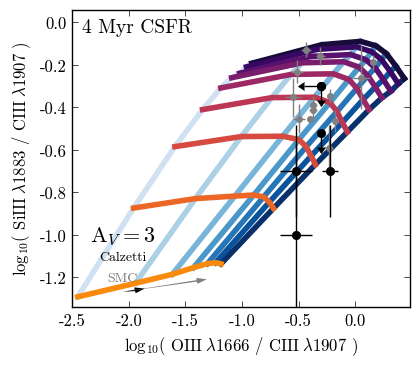

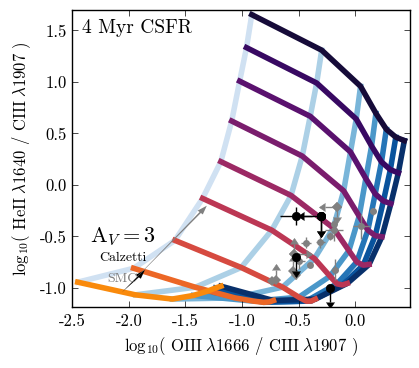

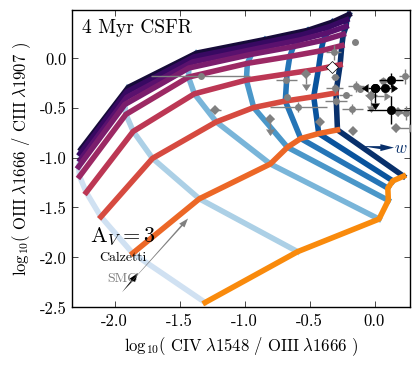

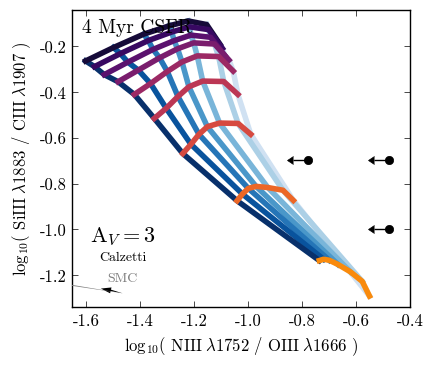

In [32]:
#------------------------------------
xname = 'log_OIII_1666_CIII_1906'
xlab = '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )'
xratio = ('OIII_1666', 'CIII_1906')

yname = 'log_SiIII_1883_CIII_1906'
ylab = '$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1907 )'
yratio = ('SiIII_1883', 'CIII_1906')

#####
fig, ax = plt.subplots(1, figsize=(4.5,4))
#
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_stark_ratio(xratio, yratio, ax=ax, zorder=5)
plot_berg_ratio(xratio, yratio, ax=ax, zorder=3)
plot_sench_ratio(xratio, yratio, ax=ax, zorder=3)
#
#make_inset(axlims=[.7, .27, .25, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1]+0.1)
fig.savefig('../figs/f20a.pdf')
fig.savefig('../figs/f20a.png')
#------------------------------------
#####
yname, ylab, yratio = 'log_HeII_1640_CIII_1906', '$\\log_{10}$( HeII$\\;\\lambda$1640 / CIII$\\;\\lambda$1907 )', ('HeII_1640', 'CIII_1906')
xname, xlab, xratio = 'log_OIII_1666_CIII_1906', '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )', ('OIII_1666', 'CIII_1906')
#####
fig, ax = plt.subplots(1, figsize=(4.5,4))
#
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_stark_ratio(xratio, yratio, ax=ax, zorder=5)
plot_berg_ratio(xratio, yratio, ax=ax, zorder=3)
plot_sench_ratio(xratio, yratio, ax=ax, zorder=3)
#
#make_inset(axlims=[.7, .27, .25, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
fig.savefig('../figs/f20b.pdf')
fig.savefig('../figs/f20b.png')
#------------------------------------
yname = r'log_OIII_1666_CIII_1906'
ylab = '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )'
yratio = ('OIII_1666', 'CIII_1906')

xname = 'log_CIV_1548_OIII_1666'
xlab = '$\\log_{10}$( CIV$\\;\\lambda$1548 / OIII$\\;\\lambda$1666 )'
xratio = ('CIV_1548', 'OIII_1666')
#####
fig, ax = plt.subplots(1, figsize=(4.5,4))
#
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_stark_ratio(xratio, yratio, ax=ax, zorder=5)
plot_berg_ratio(xratio, yratio, ax=ax, zorder=3)
plot_sench_ratio(xratio, yratio, ax=ax, zorder=3)
#wind_arrow(0.25, -0.27, ax=ax, width=0.03, head_width=0.06)
wind_arrow(-0.1, -0.9, ax=ax, dx=0.25, dy=0.0, label=r'$w$',
           xshift=5, yshift=0, width=0.03, head_width=0.07)

xx = np.log10(OIII_1666[0][0]/CIII_1906[0][0])
xe = ((OIII_1666[0][1]/(OIII_1666[0][0]*np.log(10)))**2.0 + (CIII_1906[0][1]/(CIII_1906[0][0]*np.log(10)))**2.0)**0.5
yy = np.log10(CIV_1548[0][0]/CIII_1906[0][0])
ye = ((CIV_1548[0][1]/(CIV_1548[0][0]*np.log(10)))**2.0 + (CIII_1906[0][1]/(CIII_1906[0][0]*np.log(10)))**2.0)**0.5
ax.errorbar(log_CIV_OIII, log_OIII_CIII, xerr=xe, yerr=ye, ecolor='k', capsize=0,
            color='white', marker='D', markeredgecolor='k', zorder=10)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
fig.savefig('../figs/f20c.pdf'.format(xname, yname))
fig.savefig('../figs/f20c.png'.format(xname, yname))
######
#------------------------------------

#####
xname, xlab, xratio = 'log_NIII_1752_OIII_1666','$\\log_{10}$( NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 )',('NIII_1752','OIII_1666')
yname, ylab, yratio = 'log_SiIII_1883_CIII_1906', '$\\log_{10}$( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1907 )', ('SiIII_1883','CIII_1906')#####
fig, ax = plt.subplots(1, figsize=(4.5,4))
#
ratio_ratio(zau, xname, xratio, xlab, yname, yratio, ylab,
            ax=ax, figy=0.05, age=4.e6, av_ind=av_ind)
plot_stark_ratio(xratio, yratio, ax=ax, zorder=4)
plot_berg_ratio(xratio, yratio, ax=ax, color='silver', zorder=3)
#
#make_inset(axlims=[.7, .27, .25, .15], pad=0)
ax.annotate('4 Myr CSFR', xy=(0.03,0.97),
            xycoords='axes fraction',
            fontsize=14, ha='left', va='top')
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1]+0.1)
fig.savefig('../figs/f20d.pdf')
fig.savefig('../figs/f20d.png')


In [33]:

dir_ = '/astro/users/ebyler/research/uvem/output_epoch/'
mod_prefix='ZAU'
zau = ob.allmods(dir_, mod_prefix,
                 read_out=True, read_rad=True, read_cool=True)
[mod.__setattr__('gas_logZ', mod.fbhb) for mod in zau.mods]
zau.add_arrs('gas_logZ')
zau.gas_logZ_vals = np.unique(zau.gas_logZ)

###
dir_='/astro/users/ebyler/research/uvem/data'
gg = modObj(dir_+'/ZAU_CSFR_ext_b_lum.lines')

In [34]:
uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

i = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            i += 1
            float_lambda = float(u[1])
            if float_lambda < 3900.0:
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam

[mod.add_lines(ulined) for mod in zau.mods]
zau.add_arrs(*ulined.keys())
zau.add_arrs('Ha', 'Hb')

#zau.add_lines(ulined)
gg.add_lines(ulined)

In [35]:
def zpxl_plot(zau, Zstar=-1.0, ax=None, do_label=False,
             zname='log_NIIb_Ha', # line ratios to plot
             cb_label='log[ N II/ Ha ]', # line ratios to plot
             grid_xname='logU', grid_yname='logZ', # grids in logU and log Z
             xlim=(-2.0, 1.0), ylim=(-2.0, 1.0), # axis limits
             cname='inferno', xv=(0.2, 1.0), yv=(0.2, 0.9), # color properties
             lw=4, alpha=1.0, # line properties
             xclims=(-4.0, -1.0), yclims=(-2.0, 0.5),
             cmap=None, sM=None, cNorm=None, cb_arr=None,
             no_cbar=False, show_grid=False, aspect='auto',
             xlabels=None, ylabels=None, special_x=None, special_y=None,
             xax_lab=None, yax_lab=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1)
    #####
    # calculate grid
    #####
    use_inds = [i for i in range(zau.nmods) if ((zau.logZ[i] == Zstar) and \
                                                (zau.__getattribute__(grid_xname)[i] >= xclims[0]) and \
                                                (zau.__getattribute__(grid_xname)[i] <= xclims[1]) and \
                                                (zau.__getattribute__(grid_yname)[i] >= yclims[0]) and \
                                                (zau.__getattribute__(grid_yname)[i] <= yclims[1]))]
    
    grid_x = np.array([x for x in zau.__getattribute__(grid_xname+'_vals') if (x >= xclims[0]) & (x <= xclims[1])])
    grid_y = np.array([y for y in zau.__getattribute__(grid_yname+'_vals') if (y >= yclims[0]) & (y <= yclims[1])])
    
    if special_x is not None:
        grid_x = np.array([x for x in zau.__getattribute__(grid_xname+'_vals') if x in special_x])
        grid_y = np.array([y for y in zau.__getattribute__(grid_yname+'_vals') if y in special_y])
        use_inds = [i for i in range(zau.nmods) if ((zau.logZ[i] == Zstar) and \
                                                (zau.__getattribute__(grid_xname)[i] in special_x) and \
                                                (zau.__getattribute__(grid_yname)[i] in special_y))]
    
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = np.zeros_like(X)
    for index, x in np.ndenumerate(Z):
        mind = [i for i in use_inds
                if (zau.__getattribute__(grid_xname)[i] == X[index]
                    and zau.__getattribute__(grid_yname)[i] == Y[index])]
        try:
            Z[index] = zau.__getattribute__(zname)[mind[0]]
        except AttributeError:
            print('not a valid attribute.')
    masked_array = np.ma.array(Z, mask=np.isnan(Z))
    ####
    # 
    ####
    if grid_xname == 'age':
        X*=1.0e-6
    if grid_yname == 'age':
        Y*=1.0e-6
    ####
    # color bar crap
    ####
    if (sM is None) or (cNorm is None):
        if cb_arr is not None:
            arr_in = cb_arr
        else:
            arr_in = masked_array
        if cmap is not None:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cmap=cmap)
        else:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cname=cname)
        cmap = plt.get_cmap(cname)
    pf = ax.imshow(Z, norm=cNorm, aspect=aspect,
                   interpolation='nearest', origin='lower',
                   cmap=cmap)
    xCenters = X[0]
    yCenters = Y[:,0]
    if xlabels is None:
        xlabels = ['{0:.1f}'.format(x) for x in xCenters]
    if ylabels is None:
        ylabels = ['{0:.1f}'.format(y) for y in yCenters]
    for axis, labels in zip([ax.xaxis, ax.yaxis], [xlabels, ylabels]):
        locs = np.arange(len(labels))
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
    if show_grid:
        ax.grid(True, which='minor')
    if xax_lab is None:
        xax_lab = grid_xname
        yax_lab = grid_yname
    ax.set_xlabel(xax_lab, fontsize=14)
    ax.set_ylabel(yax_lab, fontsize=14)
    if no_cbar:
        return pf
    else:
        cb = plt.colorbar(pf, ax=ax)
        if cb_label is not None:
            cb_lab_size=kwargs.get('cb_lab_size', 12)
            cb.set_label(cb_label, size=cb_lab_size)
        cb.ax.tick_params(labelsize=10) 
        return ax

# Fig.27: decoupled star + gas metallicities

### Fig.27 (a)

In [36]:
stellarZ = -1.0
gasZ = -0.5
logU = -1.0
EE_ind = np.where((zau.logZ == stellarZ) & (zau.gas_logZ == gasZ) & (zau.logU == logU))[0][0]
norm_ind = np.where((zau.logZ == stellarZ) & (zau.gas_logZ == stellarZ) & (zau.logU == logU))[0][0]
ee = zau.mods[EE_ind]
nn = zau.mods[norm_ind]

print zau.gas_logZ_vals

[-2.5  -2.   -1.5  -1.   -0.75 -0.5  -0.25  0.    0.25  0.5 ]


73 74
75 76
93 94
95 96
113 114
115 116
133 134
135 136


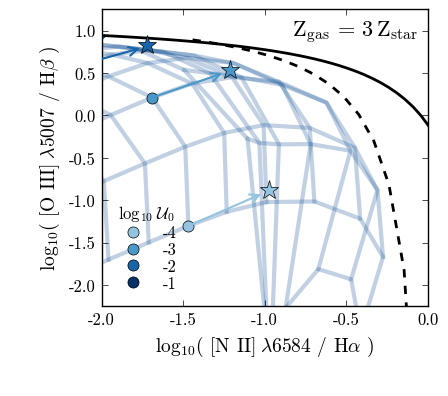

In [37]:
age = 4.e6
sMx = getColors(np.linspace(-2.0, 0.5), cname='inferno', minv=0.1, maxv=0.9)

# data
sxname = 'logNHa'
syname = 'log_OIII_Hb'
xlim=[-1.7, 0.1]
ylim=[-2.4, 1.2]
xlab=r'$\log_{10}$( [N II]$\;\lambda$6584 / H$\alpha$ )'
ylab=r'$\log_{10}$( [O III]$\;\lambda$5007 / H$\beta$ )'
#### plotting
fig, ax = plt.subplots(1,1, figsize=(4.5,4.))
##plot_2Dhist(sample[sxname], sample[syname], ranges=[[-2.0,0.0], ylim], ax=ax,
#            cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
# add lines
NII = np.linspace(-4.5, 0.04)
OIII = 0.61/(NII - 0.05) + 1.3
ax.plot(NII[NII >= -1.5], OIII[NII >= -1.5], '--', color='k', lw=2)
NII = np.linspace(-4.5, 0.46, 100)
OIII = 0.61/(NII - 0.47) + 1.19
ax.plot(NII, OIII, color='k', lw=2)

#for stellarZ in zau.logZ_vals:
#for stellarZ in [-1.]:
# add models
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
xname, yname='log_NIIb_Ha','log_OIIIb_Hb'
altBPT(gg, ax=ax, age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.9, cname='Blues', alpha=0.25))

Zstar = -1.0
Zgas = -0.5

sMu = getColors(zau.logU_vals, cname='Blues', minv=0.4, maxv=1.0)
for logU in [-4.0, -3.0, -2.0, -1.0]:
    Ucol = sMu.to_rgba(logU)
    Ulab = '{0:.0f}'.format(logU)
    ind = np.where((zau.logZ == Zstar) & \
                    (zau.gas_logZ == Zstar) & \
                    (zau.logU == logU))[0][0]
    print ind, zau.mods[ind].modnum
    x1 = zau.log_NIIb_Ha[ind]
    y1 = zau.log_OIIIb_Hb[ind]
    
    ind = np.where((zau.logZ == Zstar) & \
                    (zau.gas_logZ == Zgas) & \
                    (zau.logU == logU))[0][0]
    print ind, zau.mods[ind].modnum
    x2 = zau.log_NIIb_Ha[ind]
    y2 = zau.log_OIIIb_Hb[ind]
    ax.plot(x1, y1, marker='o', color=Ucol,
            mec='k', markersize=8, zorder=3, label=Ulab, ls='None')
    ax.plot(x2, y2, marker='*', color=Ucol,
            mec='k', markersize=14, zorder=7)
    ann = ax.annotate("",
                      xy=(x2-0.03, y2-0.03), xycoords='data',
                      xytext=(x1,y1), textcoords='data',
                      ha='center', va='center',
                      arrowprops=dict(arrowstyle="->", connectionstyle='arc', color=Ucol, lw=1.5))
    ann.arrow_patch.set_clip_box(ax.bbox)
##
ax.annotate("Z$_{{\mathrm{{gas}}}}$ = {0:.0f}$\,$Z$_{{\mathrm{{star}}}}$".format(1./10.**(Zstar-Zgas)),
            xy=(0.97,0.97), xycoords="axes fraction",
            ha='right', va='top', size=16, zorder=1, annotation_clip=True)
leg = ax.legend(loc=0, title=r'$\log_{10}\;\mathcal{U}_0$', fontsize=12, numpoints=1, frameon=False)
plt.setp(leg.get_title(), fontsize=12)
ax.set_xlim(-2.0, 0.0)
ax.set_ylim(-2.25, 1.25)
ax.set_xlabel(xlab, size=14)
ax.set_ylabel(ylab, size=14)
fig.tight_layout()
fig.savefig('../figs/f27a.pdf')
fig.savefig('../figs/f27a.png')

### Fig.27 (b+c)

[-1.5  -1.   -0.5   0.    0.25  0.5   0.75  1.    1.25  1.5 ]
[-1.5  -1.   -0.5   0.    0.25  0.5   0.75  1.    1.25  1.5 ]


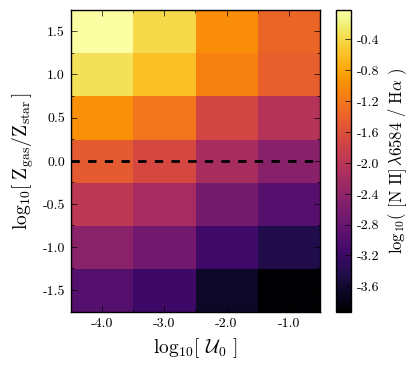

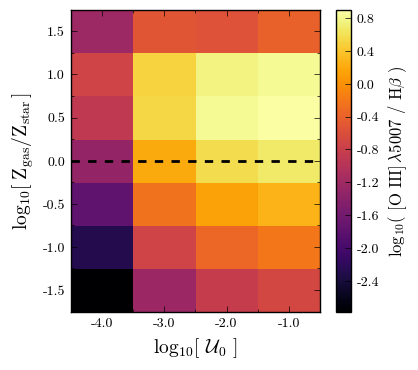

In [38]:
Zstar = -1.0
[mod.__setattr__('Zrel', mod.gas_logZ - Zstar) for mod in zau.mods]
zau.add_arrs('Zrel')
zau.Zrel_vals = np.unique(zau.Zrel)

ratios = ['log_NIIb_Ha', 'log_OIIIb_Hb']
labels = [r'$\log_{10}$( [N II]$\,\lambda$6584 / H$\alpha$ )',
          r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )']
ylabel=r'$\log_{10}[\;$Z$_{\mathrm{gas}}$/Z$_{\mathrm{star}}\,$]'
xlabel=r'$\log_{10}$[ $\mathcal{U}_0$ ]'
figlabs = ['b','c']
age=4.e6
for ratio, label, figlab in zip(ratios,labels, figlabs):
    fig,ax = plt.subplots(1, figsize=(4.5,4))
    zpxl_plot(zau, Zstar=-1.0, ax=ax,
              zname=ratio, cb_label=label,
              xax_lab=xlabel, yax_lab=ylabel,
              grid_yname='Zrel', yclims=(-2.5,2.5),
              special_x=[-4.,-3.,-2.,-1.],
              special_y=[-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
    fig.tight_layout()
    print zau.Zrel_vals
    yline = float(np.where(zau.Zrel_vals == 0.0)[0][0])
    ax.axhline(y=yline, ls='--', color='k', lw=2)
    fig.tight_layout()
    fig.savefig('../figs/f27{}.pdf'.format(figlab))
    fig.savefig('../figs/f27{}.png'.format(figlab))

# Fig.28

[-1.5  -1.   -0.5   0.    0.25  0.5   0.75  1.    1.25  1.5 ]
[-1.5  -1.   -0.5   0.    0.25  0.5   0.75  1.    1.25  1.5 ]


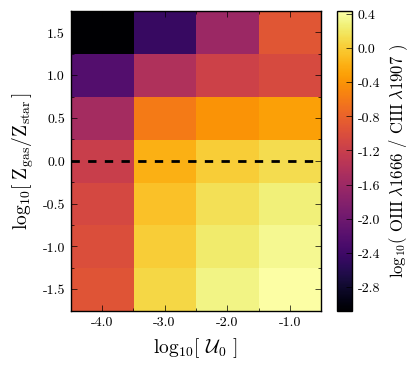

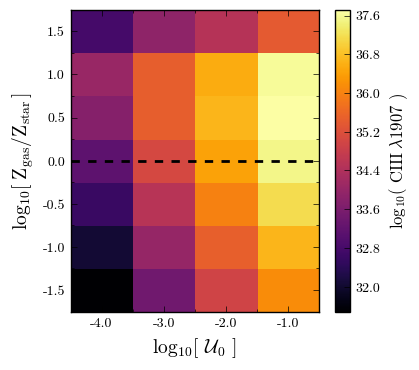

In [39]:
iis = [0,1,2,-1]
ratios = [ratio_names[i] for i in iis]
labels = [ratio_labels[i] for i in iis]

ratio = 'log_OIII_1666_CIII_1906'
label = '$\\log_{10}$( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )'
lines  = ('OIII_1666', 'CIII_1906')

arr = np.log10(zau.__getattribute__(lines[0])/zau.__getattribute__(lines[1]))
zau.__setattr__(ratio, arr)

ylabel=r'$\log_{10}[\;$Z$_{\mathrm{gas}}$/Z$_{\mathrm{star}}\,$]'
xlabel=r'$\log_{10}$[ $\mathcal{U}_0$ ]'
age=4.e6

fig,ax = plt.subplots(1, figsize=(4.5,4))
zpxl_plot(zau, Zstar=-1.0, ax=ax,
          zname=ratio, cb_label=label,
          xax_lab=xlabel, yax_lab=ylabel,
          grid_yname='Zrel', yclims=(-2.5,2.5),
          special_x=[-4.,-3.,-2.,-1.],
          special_y=[-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
fig.tight_layout()
print zau.Zrel_vals
yline = float(np.where(zau.Zrel_vals == 0.0)[0][0])
ax.axhline(y=yline, ls='--', color='k', lw=2)
fig.tight_layout()
fig.savefig('../figs/f28a.pdf')
fig.savefig('../figs/f28a.png')

ratio = 'log_CIII_1906'
label = '$\\log_{10}$( CIII$\\;\\lambda$1907 )'
lines  = 'CIII_1906'

arr = np.log10(zau.__getattribute__(lines))
zau.__setattr__(ratio, arr)

ylabel=r'$\log_{10}[\;$Z$_{\mathrm{gas}}$/Z$_{\mathrm{star}}\,$]'
xlabel=r'$\log_{10}$[ $\mathcal{U}_0$ ]'
age=4.e6

fig,ax = plt.subplots(1, figsize=(4.5,4))
zpxl_plot(zau, Zstar=-1.0, ax=ax,
          zname=ratio, cb_label=label,
          xax_lab=xlabel, yax_lab=ylabel,
          grid_yname='Zrel', yclims=(-2.5,2.5),
          special_x=[-4.,-3.,-2.,-1.],
          special_y=[-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5])
fig.tight_layout()
print zau.Zrel_vals
yline = float(np.where(zau.Zrel_vals == 0.0)[0][0])
ax.axhline(y=yline, ls='--', color='k', lw=2)
fig.tight_layout()
fig.savefig('../figs/f28b.pdf')
fig.savefig('../figs/f28b.png')

In [40]:
def plot_berg_abunds(ax=None, yval='CO',
                     label='__nolabel__', alpha=1.0, single_color=True,
                     color='royalblue', zorder=0, elinewidth=0.8):
    dat =np.genfromtxt('/astro/users/ebyler/research/uvem/data/CNO_berg.dat',
                       delimiter=',', dtype=None, names=True)
    x, xerr = dat['logO'], dat['logO_err']
    if yval == 'CO':
        y,yerr = dat['logCO'], dat['logCO_err']
    if yval == 'NO':
        y,yerr = dat['logNO'], dat['logNO_err']
    if single_color:
        ax.errorbar(x,y,xerr=xerr,yerr=yerr, elinewidth=elinewidth,
                    fmt='o', markersize=4, capsize=0, ecolor='gray', alpha=alpha,
                    color=color, markeredgecolor='None',
                    label=label, zorder=zorder)
    else:
        inds = (dat['src'] == 7)
        color = 'mediumorchid'
        ax.errorbar(x[inds],y[inds],xerr=xerr[inds],yerr=yerr[inds], elinewidth=elinewidth,
                fmt='o', markersize=4, capsize=0, ecolor='gray', alpha=alpha,
                color=color, markeredgecolor='None',
                label=label, zorder=zorder)
        inds = (dat['src'] == 2)
        color = 'royalblue'
        ax.errorbar(x[inds],y[inds],xerr=xerr[inds],yerr=yerr[inds], elinewidth=elinewidth,
                fmt='o', markersize=4, capsize=0, ecolor='gray', alpha=alpha,
                color=color, markeredgecolor='None',
                label=label, zorder=zorder)
    return

def plot_RL_abunds(ax=None, zorder=0, markersize=4,
                   label='__nolabel__', color='mediumaquamarine'):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/RL.dat',
                        delimiter=',', names=True, dtype=None)
    C_sol = -3.57
    O_sol = -3.31
    N_sol = -4.17
    x = dat['O']
    xerr = dat['O_err']
    ##
    y1 = (dat['C'] + C_sol)
    e1 = dat['C_err']
    y2 = (dat['O'] + O_sol)
    e2 = dat['O_err']
    y = y1 - y2
    yerr = (e1**2.0 + e2**2.)**0.5
    inds = (dat['C'] != -99.99)
    ax.errorbar(x[inds], y[inds], xerr=xerr[inds], yerr=yerr[inds],
                ecolor='gray', capsize=0, 
                marker='D', markersize=4, label=label,
                ls='None', color=color, markeredgecolor='None',
                zorder=zorder)
    return
def plot_RL2_abunds(ax=None, color='k', zorder=0, markersize=4,
                   label='__nolabel__'):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/RL_log.dat',
                        delimiter=',', names=True, dtype=None)
    C_sol = -3.57
    O_sol = -3.31
    N_sol = -4.17
    y = dat['logNO']
    yerr = dat['logNO_err']
    x = dat['logO']
    xerr = dat['logO_err']
    ax.errorbar(x, y, xerr=xerr, yerr=yerr,
                ecolor='gray', capsize=0, 
                marker='D', markersize=4, label=label,
                ls='None', color='limegreen', markeredgecolor='None',
                zorder=zorder)
    return
def plot_DLA_abunds(ax=None, color='k', zorder=0, markersize=4,
                    label='__nolabel__'):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/DLAs_Cooke.dat',
                        delimiter=',', names=True, dtype=None)
    C_sol = -3.57
    O_sol = -3.31
    N_sol = -4.17
    x = dat['O'] + O_sol + 12.
    xerr = dat['O_err']
    ##
    y1 = (dat['C'] + C_sol)
    e1 = dat['C_err']
    y2 = (dat['O'] + O_sol)
    e2 = dat['O_err']
    y = y1 - y2
    yerr = (e1**2.0 + e2**2.)**0.5
    inds = (dat['C'] != -99.99)
    ax.errorbar(x[inds], y[inds], xerr=xerr[inds], yerr=yerr[inds],
                ecolor='gray', capsize=0, 
                marker='D', markersize=4, label=label,
                ls='None', color='orange', markeredgecolor='None',
                zorder=zorder)
    return

def plot_NO(ax=None, lab='__nolabel__', plot_dop=False, alpha=0.6, markersize=4,
            color='white', mec='black', ecolor='grey', elinewidth=0.8, **kwargs):
    dir_='/astro/users/ebyler/python/cloudyfsps/cloudyfsps/astrodata/data/'
    linefile = dir_+'vanzee_abund.dat'
    data = np.genfromtxt(linefile, delimiter='\t',
                         names='temp, logO, logOerr, logNO, logNOerr')
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(data['logO'], data['logNO'],
                xerr=data['logOerr'], yerr=data['logNOerr'], capsize=0, elinewidth=elinewidth,
                marker='o', ecolor=ecolor, mec=mec, color=color, alpha=alpha,
                linestyle='None', markersize=markersize, label=lab, zorder=-3)
    return

def berg_line(ax=None, lab='__nolabel__', color='k', alpha=1.0, lw=1.5, ls='--', zorder=10):
    xx = np.linspace(6.0, 9.5)
    yy = -5.49+(0.51*xx)
    ax.plot(xx[xx >= 7.7], yy[xx >= 7.7],
            lw=lw, color=color, alpha=alpha, label=lab, ls=ls, zorder=zorder)
    ax.plot(xx[xx < 7.7], np.zeros_like(xx[xx < 7.7])-1.56,
            lw=lw, color=color, alpha=alpha, label='__nolabel__', ls=ls, zorder=zorder)
    return

def plot_pil_abunds(ax=None, color='k', zorder=0, markersize=4,
                    label='__nolabel__'):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/pilyugin2012.dat',
                        names=True, dtype=None, skip_header=45)
    x = dat['logO12']
    y = dat['logN12']-dat['logO12']
    ax.plot(x, y,
            marker='+', markersize=4, label=label,
            ls='None', color=color, zorder=zorder)
    return
def plot_vz_abunds(ax=None, zorder=0, lab='__nolabel__',
                   markersize=4, color='white', alpha=0.6,
                   mec='black', ecolor='grey', elinewidth=0.8):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/vanzee06.dat',
                        names=True, dtype=None, skip_header=49)
    x,xerr = dat['logO12'], dat['logO12_err']
    y,yerr = dat['logNO'], dat['logNO_err']
    ax.errorbar(x, y,xerr=xerr, yerr=yerr, mec=mec,
                elinewidth=elinewidth, capsize=0, alpha=alpha,
                marker='o', markersize=markersize, label=lab,
                ls='None', color=color, zorder=zorder)
    return
def plot_B12_abunds(ax=None, addit=False, zorder=0, lab='__none__',
                    markersize=4, color='dodgerblue', alpha=0.6,
                    mec='None', elinewidth=0.8, acolor='skyblue'):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/berg_2012.dat', delimiter=',', names=True, dtype=None)
    x,y = dat['logO12'],dat['logNO']
    ax.plot(x, y, mec=mec, alpha=alpha, marker='o',
            markersize=markersize, label=lab,
            ls='None', color=color, zorder=zorder)
    if addit:
        adat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/berg_2012_add.dat', delimiter=',', names=True, dtype=None)
        x,y = adat['logO12'],adat['logNO']
        ax.plot(x, y, mec=mec, alpha=alpha, marker='o',
            markersize=markersize, label=lab,
            ls='None', color=acolor, zorder=zorder)
    return
def plot_C12_abunds(ax=None, addit=False, zorder=0, lab='__none__',
                    markersize=4, color='darkcyan', alpha=0.6,
                    mec='None', elinewidth=0.8):
    dat = np.genfromtxt('/astro/users/ebyler/research/uvem/data/Contini_2002.dat', delimiter=',', names=True, dtype=None)
    x,y = dat['logO12'],dat['logNO']
    ax.plot(x, y, mec=mec, alpha=alpha, marker='o',
            markersize=markersize, label=lab,
            ls='None', color=color, zorder=zorder)
    return


In [41]:
x_sol, yC_sol, yN_sol = (-3.31+12.), (-3.57)-(-3.31), (-4.17)-(-3.31)

In [42]:
old_sol = -3.07
new_sol = -3.31
g_sol = -3.17

logZs = np.linspace(-2.5, 0.5, 40)
old_logOs = logZs + old_sol + 12.
new_logOs = logZs + new_sol + 12.
g_logOs = logZs + g_sol + 12.

set_labs = ['D01', 'D13', 'G16', 'this work']
set_names = ['dopita', 'newdopita', 'gutkin', 'UVbyler']
n_depls = [-0.22, -0.05, 0.0, -0.05]
c_depls = [-0.3, -0.3, -0.3, -0.3]
o_depls = [-0.22, -0.07, -0.15, -0.07]

colors = ['darkorange', 'purple', 'forestgreen', 'mediumblue']
logOs = [old_logOs, new_logOs, g_logOs, new_logOs]
dust=False
re_z=False

In [43]:
from cloudyfsps.nebAbundTools import getNebAbunds

# Fig.21: N/O and C/O vs metallicity

In [44]:
logZs = np.linspace(-2.5, 0.5, 40)
dust=False
re_z=False
set_name = 'newdopita'
O_D13, N_D13, C_D13 = [],[],[]
for logZ in logZs:
    abunds = getNebAbunds(set_name, logZ, dust=dust, re_z=re_z)
    C_D13.append(abunds.C + (-1.0*abunds.depl['C']))
    N_D13.append(abunds.N + (-1.0*abunds.depl['N']))
    O_D13.append(abunds.O + (-1.0*abunds.depl['O']))

logO_D13 = abunds.abund_0['O']+logZs+12.
CO_D13 = np.array(C_D13) - np.array(O_D13)
NO_D13 = np.array(N_D13) - np.array(O_D13)

set_name = 'dopita'
O_D00, N_D00, C_D00 = [],[],[]
for logZ in logZs:
    abunds = getNebAbunds(set_name, logZ, dust=dust, re_z=re_z)
    C_D00.append(abunds.C + (-1.0*abunds.depl['C']))
    N_D00.append(abunds.N + (-1.0*abunds.depl['N']))
    O_D00.append(abunds.O + (-1.0*abunds.depl['O']))

logO_D00 = abunds.abund_0['O']+logZs+12.
CO_D00 = np.array(C_D00) - np.array(O_D00)
NO_D00 = np.array(N_D00) - np.array(O_D00)

set_name = 'gutkin'
O_G, N_G, C_G = [],[],[]
C_sol_g = 0.0
for logZ in logZs:
    abunds = getNebAbunds(set_name, logZ, dust=dust, re_z=re_z)
    C_G.append(abunds.C + (-1.0*abunds.depl['C']))
    N_G.append(abunds.N)
    O_G.append(abunds.O + (-1.0*abunds.depl['O']))
    if logZ == 0.0:
        C_sol_g = abunds.C+ (-1.0*abunds.depl['C'])

logO_G = abunds.abund_0['O']+logZs+12.
CO_G = np.array(C_G) - np.array(O_G)
NO_G = np.array(N_G) - np.array(O_G)

set_name = 'UVbyler'
O_b, N_b, C_b = [],[],[]
for logZ in logZs:
    abunds = getNebAbunds(set_name, logZ, dust=dust, re_z=re_z)
    C_b.append(abunds.C + (-1.0*abunds.depl['C']))
    N_b.append(abunds.N + (-1.0*abunds.depl['N']))
    O_b.append(abunds.O + (-1.0*abunds.depl['O']))

logO_b = abunds.abund_0['O']+logZs+12.
CO_b = np.array(C_b) - np.array(O_b)
NO_b = np.array(N_b) - np.array(O_b)

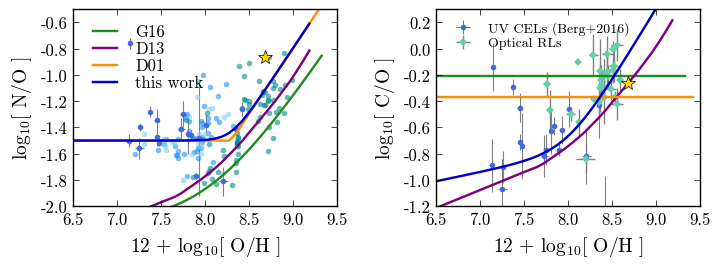

In [45]:
fig, axes = plt.subplots(1,2, figsize=(7.5,3))
# -------- N/O -----------------------------------------------------
ax = fig.axes[0]
ax.plot(logO_G, NO_G, color='forestgreen', lw=1.75, label='G16')
ax.plot(logO_D13, NO_D13, color='purple', lw=1.75, label='D13')
ax.plot(logO_D00, NO_D00, color='darkorange', lw=1.75, label='D01')
ax.plot(logO_b, NO_b, color='mediumblue', lw=1.75, label='this work')
####################
ax.set_xlabel(r'12 + $\log_{10}$[ O/H ]', size=14)
ax.set_ylabel(r'$\log_{10}$[ N/O ]', size=14)
ax.set_xlim(6.5,9.5)
ax.set_ylim(-2., -0.5)
####################
#plot_vz_abunds(ax=ax)
plot_B12_abunds(ax=ax, addit=True)
plot_C12_abunds(ax=ax)
#plot_NO(ax=ax)
plot_berg_abunds(ax=ax, yval='NO', single_color=True)#, label='Berg+2016')

ax.plot(x_sol, yN_sol, color='gold', marker='*', markersize=10, mec='k', zorder=10)
ax.legend(frameon=False, loc=0, fontsize=12)
# -------- C/O -----------------------------------------------------
ax = fig.axes[1]
ax.plot(logO_G, CO_G, color='forestgreen', lw=1.75, label='__nolabel__')
ax.plot(logO_D13, CO_D13, color='purple', lw=1.75, label='__nolabel__')
ax.plot(logO_D00, CO_D00, color='darkorange', lw=1.75, label='__nolabel__')
ax.plot(logO_b, CO_b, color='mediumblue', lw=1.75, label='__nolabel__')
####################
ax.set_xlabel(r'12 + $\log_{10}$[ O/H ]', size=14)
ax.set_ylabel(r'$\log_{10}$[ C/O ]', size=14)
ax.set_xlim(6.5, 9.5)
ax.set_ylim(-1.2, 0.3)
####################
plot_berg_abunds(ax=ax, yval='CO', label='UV CELs (Berg+2016)', single_color=True)
#plot_stellar_abunds(ax=ax, label='__nolabel__')
#plot_halo_abunds(ax=ax, label='__nolabel__')
plot_RL_abunds(ax=ax, label='Optical RLs')

ax.plot(x_sol, yC_sol, color='gold', marker='*', markersize=10, mec='k', zorder=10)
ax.legend(frameon=False, loc=0, numpoints=1, fontsize=10)
####################
fig.tight_layout()

fig.savefig('../figs/f21.pdf')
fig.savefig('../figs/f21.png')

In [46]:
from cloudyfsps.nebAbundTools import getNebAbunds
abunds = getNebAbunds('UVbyler', 0.0, dust=False, re_z=False)
solar_CO = abunds.C-abunds.O

In [47]:
dir_ = '/astro/users/ebyler/research/uvem/output_CO/'
## these are the models that have fixed O/H = 0.0
## and C/O is varied from -1.0 to 0.0 times solar CO value
mod_prefix='ZAU'
zau = ob.allmods(dir_, mod_prefix,
                 read_out=True)
# gas_logZ is the scale from abund_0['C']
[mod.__setattr__('gas_logZ', mod.fbhb) for mod in zau.mods]
zau.add_arrs('gas_logZ')
zau.gas_logZ_vals = np.unique(zau.gas_logZ)
# so I don't forget what the orig values are
#C_0 = -3.57
#C_d = -0.3
#O_0 = -3.31
#O_d = -0.07
# i don't think i should actually re-correct for depletion
[mod.__setattr__('CO', (mod.gasC)-(mod.gasO)) for mod in zau.mods]
zau.add_arrs('CO')
[mod.__setattr__('lognH', np.log10(mod.nH)) for mod in zau.mods]
zau.add_arrs('lognH')
zau.lognH_vals = np.unique(zau.lognH)

[mod.__setattr__('diffCO', mod.CO-solar_CO) for mod in zau.mods]
zau.add_arrs('diffCO')
zau.diffCO_vals = np.unique(zau.diffCO)

for mod in zau.mods:
    abunds = getNebAbunds('UVbyler', mod.logZ, dust=False, re_z=False)
    mod.dC = float('{0:.2f}'.format(mod.gasC - abunds.C))
zau.add_arrs('dC')
zau.dC_vals = np.unique(zau.dC)
print zau.dC_vals

[-1.   -0.75 -0.5  -0.25 -0.    0.25  0.5   0.75  1.  ]


In [48]:
uvdat = np.genfromtxt('/astro/users/ebyler/python/mangst/mangst/emLines_UV.dat', delimiter='\t', dtype=None)
ulines = []
ulined = {}

i = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            i += 1
            float_lambda = float(u[1])
            if float_lambda < 3900.0:
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
# add them to the object
[mod.add_lines(ulined) for mod in zau.mods]
zau.add_arrs(*ulined.keys())
zau.add_arrs('Ha', 'Hb')


In [49]:
def upxl_plot(zau, logU=-2.5, logZ=0.0, ax=None, do_label=False,
             zname='log_NIIb_Ha', # line ratios to plot
             cb_label='log[ N II/ Ha ]', # line ratios to plot
             grid_xname='age', grid_yname='logZ', # grids in logU and log Z
             xlim=(-2.0, 1.0), ylim=(-2.0, 1.0), # axis limits
             cname='inferno', xv=(0.2, 1.0), yv=(0.2, 0.9), # color properties
             lw=4, alpha=1.0, # line properties
             xclims=(0.5e6, 10.e6), yclims=(-2.0, 0.5),
             cmap=None, sM=None, cNorm=None, cb_arr=None,
             no_cbar=False, show_grid=False, aspect='auto',
             xlabels=None, ylabels=None,
             xax_lab=None, yax_lab=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1)
    #####
    # calculate grid
    #####
    use_inds = [i for i in range(zau.nmods) if ((zau.logU[i] == logU) and (zau.logZ[i] == logZ) and \
                                                (zau.__getattribute__(grid_xname)[i] >= xclims[0]) and \
                                                (zau.__getattribute__(grid_xname)[i] <= xclims[1]) and \
                                                (zau.__getattribute__(grid_yname)[i] >= yclims[0]) and \
                                                (zau.__getattribute__(grid_yname)[i] <= yclims[1]))]
    grid_x = np.array([x for x in zau.__getattribute__(grid_xname+'_vals') if (x >= xclims[0]) & (x <= xclims[1])])
    grid_y = np.array([y for y in zau.__getattribute__(grid_yname+'_vals') if (y >= yclims[0]) & (y <= yclims[1])])
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = np.zeros_like(X)
    for index, x in np.ndenumerate(Z):
        mind = [i for i in use_inds #[i for i in range(zau.nmods)
                if (zau.__getattribute__(grid_xname)[i] == X[index]
                    and zau.__getattribute__(grid_yname)[i] == Y[index])]
        try:
            Z[index] = zau.__getattribute__(zname)[mind[0]]
        except AttributeError:
            print('not a valid attribute.')
    masked_array = np.ma.array(Z, mask=np.isnan(Z))
    ####
    # 
    ####
    if grid_xname == 'age':
        X*=1.0e-6
    if grid_yname == 'age':
        Y*=1.0e-6
    ####
    # color bar crap
    ####
    if (sM is None) or (cNorm is None):
        if cb_arr is not None:
            arr_in = cb_arr
        else:
            arr_in = masked_array
        if cmap is not None:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cmap=cmap)
        else:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cname=cname)
        cmap = plt.get_cmap(cname)
    pf = ax.imshow(Z, norm=cNorm, aspect=aspect,
                   interpolation='nearest', origin='lower',
                   cmap=cmap)
    xCenters = X[0]
    yCenters = Y[:,0]
    if xlabels is None:
        xlabels = ['{0:.0f}'.format(x) for x in xCenters]
    if ylabels is None:
        ylabels = ['{0:.1f}'.format(y) for y in yCenters]
    for axis, labels in zip([ax.xaxis, ax.yaxis], [xlabels, ylabels]):
        locs = np.arange(len(labels))
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    if show_grid:
        ax.grid(True, which='minor')
    if xax_lab is None:
        xax_lab = grid_xname
        yax_lab = grid_yname
    ax.set_xlabel(xax_lab)
    ax.set_ylabel(yax_lab)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
    if no_cbar:
        return pf
    else:
        cb = plt.colorbar(pf, ax=ax)
        if cb_label is not None:
            cb_lab_size=kwargs.get('cb_lab_size', 14)
            cb.set_label(cb_label, size=cb_lab_size)
        cb.ax.tick_params(labelsize=10) 
        return ax

def npxl_plot(zau, nH=100., logZ=0.0, ax=None, do_label=False,
             zname='log_NIIb_Ha', # line ratios to plot
             cb_label='log[ N II/ Ha ]', # line ratios to plot
             grid_xname='age', grid_yname='logZ', # grids in logU and log Z
             xlim=(-2.0, 1.0), ylim=(-2.0, 1.0), # axis limits
             cname='inferno', xv=(0.2, 1.0), yv=(0.2, 0.9), # color properties
             lw=4, alpha=1.0, # line properties
             xclims=(0.5e6, 10.e6), yclims=(-2.0, 0.5),
             cmap=None, sM=None, cNorm=None, cb_arr=None,
             no_cbar=False, show_grid=False, aspect='auto',
             xlabels=None, ylabels=None,
             xax_lab=None, yax_lab=None, **kwargs):
    if ax is None:
        fig, ax = plt.subplots(1)
    #####
    # calculate grid
    #####
    use_inds = [i for i in range(zau.nmods) if ((zau.nH[i] == nH) and (zau.logZ[i] == logZ) and \
                                                (zau.__getattribute__(grid_xname)[i] >= xclims[0]) and \
                                                (zau.__getattribute__(grid_xname)[i] <= xclims[1]) and \
                                                (zau.__getattribute__(grid_yname)[i] >= yclims[0]) and \
                                                (zau.__getattribute__(grid_yname)[i] <= yclims[1]))]
    grid_x = np.array([x for x in zau.__getattribute__(grid_xname+'_vals') if (x >= xclims[0]) & (x <= xclims[1])])
    grid_y = np.array([y for y in zau.__getattribute__(grid_yname+'_vals') if (y >= yclims[0]) & (y <= yclims[1])])
    X, Y = np.meshgrid(grid_x, grid_y)
    Z = np.zeros_like(X)
    for index, x in np.ndenumerate(Z):
        mind = [i for i in use_inds #[i for i in range(zau.nmods)
                if (zau.__getattribute__(grid_xname)[i] == X[index]
                    and zau.__getattribute__(grid_yname)[i] == Y[index])]
        try:
            Z[index] = zau.__getattribute__(zname)[mind[0]]
        except AttributeError:
            print('not a valid attribute.')
    masked_array = np.ma.array(Z, mask=np.isnan(Z))
    ####
    # 
    ####
    if grid_xname == 'age':
        X*=1.0e-6
    if grid_yname == 'age':
        Y*=1.0e-6
    ####
    # color bar crap
    ####
    if (sM is None) or (cNorm is None):
        if cb_arr is not None:
            arr_in = cb_arr
        else:
            arr_in = masked_array
        if cmap is not None:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cmap=cmap)
        else:
            sM, cNorm = getColors(arr_in, return_cNorm=True,
                                  set_bad_vals=True, cname=cname)
        cmap = plt.get_cmap(cname)
    pf = ax.imshow(Z, norm=cNorm, aspect=aspect,
                   interpolation='nearest', origin='lower',
                   cmap=cmap)
    xCenters = X[0]
    yCenters = Y[:,0]
    if xlabels is None:
        xlabels = ['{0:.0f}'.format(x) for x in xCenters]
    if ylabels is None:
        ylabels = ['{0:.1f}'.format(y) for y in yCenters]
    for axis, labels in zip([ax.xaxis, ax.yaxis], [xlabels, ylabels]):
        locs = np.arange(len(labels))
        axis.set_ticks(locs + 0.5, minor=True)
        axis.set(ticks=locs, ticklabels=labels)
    if show_grid:
        ax.grid(True, which='minor')
    if xax_lab is None:
        xax_lab = grid_xname
        yax_lab = grid_yname
    ax.set_xlabel(xax_lab)
    ax.set_ylabel(yax_lab)
    plt.setp(ax.get_xticklabels(), fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)
    if no_cbar:
        return pf
    else:
        cb = plt.colorbar(pf, ax=ax)
        if cb_label is not None:
            cb_lab_size=kwargs.get('cb_lab_size', 14)
            cb.set_label(cb_label, size=cb_lab_size)
        cb.ax.tick_params(labelsize=10) 
        return ax

In [50]:
zau.diffCO_vals = np.unique(zau.diffCO)
zau.lognH = np.log10(zau.nH)
zau.lognH_vals = np.unique(zau.lognH)
zau.log_CIII_1906=np.log10(zau.CIII_1906)
zau.log_OIII_1666=np.log10(zau.OIII_1666)
zau.log_Ha=np.log10(zau.Ha)
zau.log_OIII_CIII = np.log10(zau.OIII_1666/zau.CIII_1906)
zau.log_CHa = zau.log_CIII_1906 - zau.log_Ha

In [51]:
##inds, = np.where((zau.dC >= xls[0]) & (zau.dC <= xls[1]) & (zau.nH == 100.))
#vv = np.unique(zau.logQ[inds]-zau.logU[inds])
#print vv

# Fig.22: C/O changes

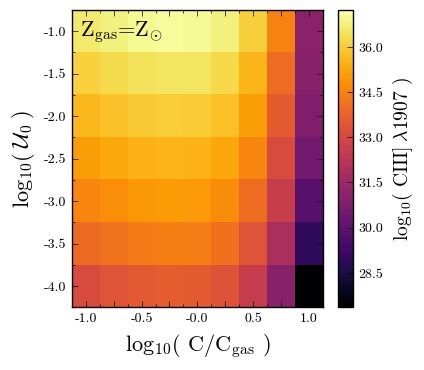

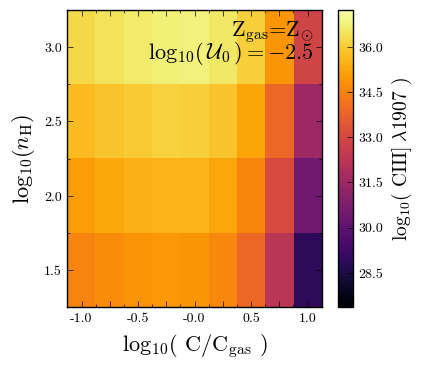

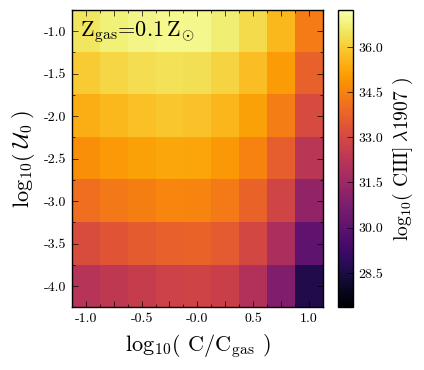

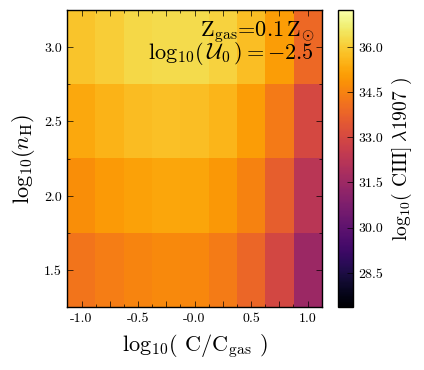

In [52]:
label =  '$\log_{10}$( CIII]$\;\lambda$1907 )'
line = 'log_CIII_1906'
#line = 'log_CHa'
xlabel=r'$\log_{10}($ C/C$_{\mathrm{gas}}$ $)$'
ylabel=r'$\log_{10}(\;\mathcal{U}_0\;)$'
logU = -2.5
logZ = 0.0
xls = (-1.1, 1.1)

logZs = [0.0, -1.0]
zlabs = [r'Z$_{\mathrm{gas}}$=Z$_{\odot}$', 
         #r'$0.3\,$Z$_{\odot}$',
         r'Z$_{\mathrm{gas}}$=$0.1\,$Z$_{\odot}$']

inds, = np.where((zau.dC >= xls[0]) & (zau.dC <= xls[1]) & (zau.nH == 100.))
cb_arr = zau.log_CIII_1906[inds]
#cb_arr = zau.log_CHa[inds]
sM, cNorm = getColors(cb_arr, cname='inferno', return_cNorm=True, maxv=1.0, minv=0.0)

figlabs = [('a','c'), ('b','d')]
for logZ, zlab, figlab in zip(logZs, zlabs, figlabs):
    ylabel=r'$\log_{10}(\;\mathcal{U}_0\;)$'
    fig,ax = plt.subplots(1, figsize=(4.5,4))
    npxl_plot(zau, nH=100., logZ=logZ, ax=ax,
              zname=line, cb_label=label,
              xax_lab=xlabel, yax_lab=ylabel, 
              yclims=(-4.,-1.0),
              grid_yname='logU',
              xclims=xls,
              grid_xname='dC',#)
              cmap=sM.cmap, sM=sM, cNorm=cNorm)
    ### make ticks prettier
    xgrid = zau.dC_vals[(zau.dC_vals >= xls[0]) & (zau.dC_vals <= xls[1])]
    xCenters = zau.dC_vals[::2]
    xlabels = ['{0:.1f}'.format(x) if x in xCenters else ' ' for x in xgrid]
    xlocs = np.arange(len(xlabels))
    ax.xaxis.set_ticks(xlocs + 0.5, minor=True)
    ax.xaxis.set(ticks=xlocs, ticklabels=xlabels)
    #ax.tick_params(axis='x', labelsize=11)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel,size=16)
    ## box around 2.5
    ls, color, lw = '-', 'k', 3
    yline = float(np.where(zau.logU_vals == -2.5)[0][0])
    #ax.axhline(y=yline+0.5, ls=ls, color=color, lw=lw)
    #ax.axhline(y=yline-0.5, ls=ls, color=color, lw=lw)
    #ax.axvline(x=xlocs[0]-0.45, ymin=0.43, ymax=0.57,
    #           ls=ls, color=color, lw=lw)
    #ax.axvline(x=xlocs[-1]+0.45, ymin=0.43, ymax=0.57,
    #           ls=ls, color=color, lw=lw)
    ##
    ax.annotate(zlab, xy=(0.03,0.97), xycoords='axes fraction',
                ha='left', va='top', size=16)
    fig.tight_layout()
    fig.savefig('../figs/f22{}.pdf'.format(figlab[0]))
    fig.savefig('../figs/f22{}.png'.format(figlab[0]))
    ###########
    ### next
    ###########
    ylabel=r'$\log_{10}(n_{\mathrm{H}})$'
    fig,ax = plt.subplots(1, figsize=(4.5,4))
    upxl_plot(zau, logU=logU, logZ=logZ, ax=ax,
              zname=line, cb_label=label,
              xax_lab=xlabel, yax_lab=ylabel, 
              yclims=(1.,4.0),
              grid_yname='lognH',
              xclims=xls,
              grid_xname='dC',#)
              cmap=sM.cmap, sM=sM, cNorm=cNorm)
    # make ticks prettier
    xgrid = zau.dC_vals[(zau.dC_vals >= xls[0]) & (zau.dC_vals <= xls[1])]
    xCenters = zau.dC_vals[::2]
    xlabels = ['{0:.1f}'.format(x) if x in xCenters else ' ' for x in xgrid]
    xlocs = np.arange(len(xlabels))
    ax.xaxis.set_ticks(xlocs + 0.5, minor=True)
    ax.xaxis.set(ticks=xlocs, ticklabels=xlabels)
    #ax.tick_params(axis='x', labelsize=11)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel,size=16)
    ax.annotate(zlab, xy=(0.97,0.97), xycoords='axes fraction',
                ha='right', va='top', size=16)
    ulab = r'$\log_{{10}}(\,\mathcal{{U}}_0\,)={{{0:.1f}}}$'.format(logU)
    ax.annotate(ulab, xy=(0.97,0.90), xycoords='axes fraction',
                ha='right', va='top', size=16)
    
    fig.tight_layout()
    fig.savefig('../figs/f22{}.pdf'.format(figlab[1]))
    fig.savefig('../figs/f22{}.png'.format(figlab[1]))

# Fig. 23

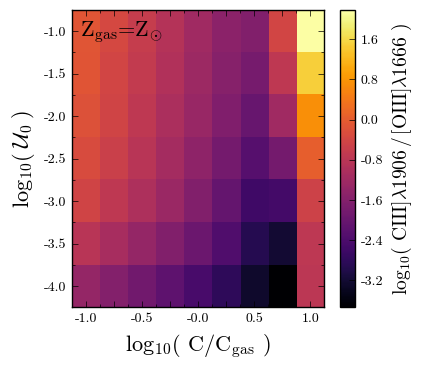

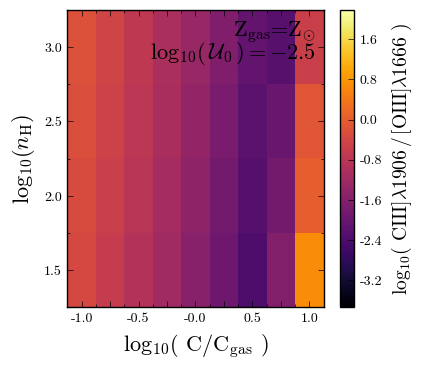

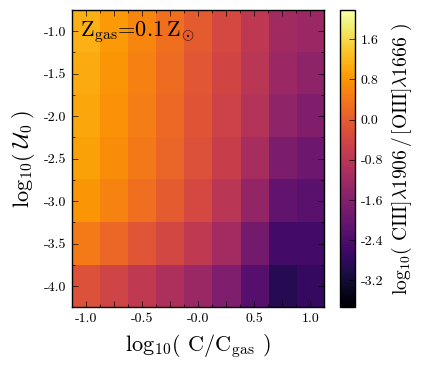

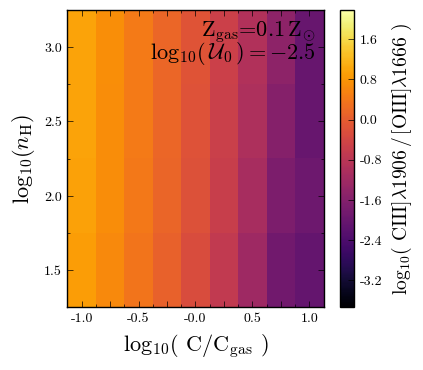

In [53]:
label =  r'$\log_{10}($ CIII]$\lambda1906\,$/$\,$[OIII]$\lambda$1666 $)$'
line = 'log_OIII_CIII'

xlabel=r'$\log_{10}($ C/C$_{\mathrm{gas}}$ $)$'
ylabel=r'$\log_{10}(\;\mathcal{U}_0\;)$'

logU = -2.5
logZ = 0.0
xls = (-1.1, 1.1)

logZs = [0.0, -1.0]
zlabs = [r'Z$_{\mathrm{gas}}$=Z$_{\odot}$', 
         #r'$0.3\,$Z$_{\odot}$',
         r'Z$_{\mathrm{gas}}$=$0.1\,$Z$_{\odot}$']
savzs = ['Z_p00','Z_m10']

inds, = np.where((zau.dC >= xls[0]) & (zau.dC <= xls[1]) & (zau.nH == 100.))
cb_arr = zau.log_OIII_CIII[inds]
sM, cNorm = getColors(cb_arr, cname='inferno', return_cNorm=True, maxv=1.0, minv=0.0)
figlabs = [('a','c'), ('b','d')]
for logZ,zlab,savz, figlab in zip(logZs, zlabs,savzs, figlabs):
    ylabel=r'$\log_{10}(\;\mathcal{U}_0\;)$'
    fig,ax = plt.subplots(1, figsize=(4.5,4))
    npxl_plot(zau, nH=100., logZ=logZ, ax=ax,
              zname=line, cb_label=label,
              xax_lab=xlabel, yax_lab=ylabel, 
              yclims=(-4.,-1.0),
              grid_yname='logU',
              xclims=xls,
              grid_xname='dC',#)
              cmap=sM.cmap, sM=sM, cNorm=cNorm)
    ### make ticks prettier
    xgrid = zau.dC_vals[(zau.dC_vals >= xls[0]) & (zau.dC_vals <= xls[1])]
    xCenters = zau.dC_vals[::2]
    xlabels = ['{0:.1f}'.format(x) if x in xCenters else ' ' for x in xgrid]
    xlocs = np.arange(len(xlabels))
    ax.xaxis.set_ticks(xlocs + 0.5, minor=True)
    ax.xaxis.set(ticks=xlocs, ticklabels=xlabels)
    #ax.tick_params(axis='x', labelsize=11)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel,size=16)
    ## box around 2.5
    ls, color, lw = '-', 'k', 3
    yline = float(np.where(zau.logU_vals == -2.5)[0][0])
    #ax.axhline(y=yline+0.5, ls=ls, color=color, lw=lw)
    #ax.axhline(y=yline-0.5, ls=ls, color=color, lw=lw)
    #ax.axvline(x=xlocs[0]-0.45, ymin=0.43, ymax=0.57,
    #           ls=ls, color=color, lw=lw)
    #ax.axvline(x=xlocs[-1]+0.45, ymin=0.43, ymax=0.57,
    #           ls=ls, color=color, lw=lw)
    ##
    ax.annotate(zlab, xy=(0.03,0.97), xycoords='axes fraction',
                ha='left', va='top', size=16)
    fig.tight_layout()
    fig.savefig('../figs/f23{}.pdf'.format(figlab[0]))
    fig.savefig('../figs/f23{}.png'.format(figlab[0]))
    ###########
    ### next
    ###########
    ylabel=r'$\log_{10}(n_{\mathrm{H}})$'
    fig,ax = plt.subplots(1, figsize=(4.5,4))
    upxl_plot(zau, logU=logU, logZ=logZ, ax=ax,
              zname=line, cb_label=label,
              xax_lab=xlabel, yax_lab=ylabel, 
              yclims=(1.,4.0),
              grid_yname='lognH',
              xclims=xls,
              grid_xname='dC',#)
              cmap=sM.cmap, sM=sM, cNorm=cNorm)
    # make ticks prettier
    xgrid = zau.dC_vals[(zau.dC_vals >= xls[0]) & (zau.dC_vals <= xls[1])]
    xCenters = zau.dC_vals[::2]
    xlabels = ['{0:.1f}'.format(x) if x in xCenters else ' ' for x in xgrid]
    xlocs = np.arange(len(xlabels))
    ax.xaxis.set_ticks(xlocs + 0.5, minor=True)
    ax.xaxis.set(ticks=xlocs, ticklabels=xlabels)
    #ax.tick_params(axis='x', labelsize=11)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel,size=16)
    ax.annotate(zlab, xy=(0.97,0.97), xycoords='axes fraction',
                ha='right', va='top', size=16)
    ulab = r'$\log_{{10}}(\,\mathcal{{U}}_0\,)={{{0:.1f}}}$'.format(logU)
    ax.annotate(ulab, xy=(0.97,0.90), xycoords='axes fraction',
                ha='right', va='top', size=16)
    
    fig.tight_layout()
    fig.savefig('../figs/f23{}.pdf'.format(figlab[1]))
    fig.savefig('../figs/f23{}.png'.format(figlab[1]))


In [54]:
# Using all line lum files
linefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_b_lum.lines'
uvb = modObj(linefile)
uvb.gas_logZ = uvb.logZ + 12. + -3.31

linefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_g_lum.lines'
gut = modObj(linefile)
gut.gas_logZ = gut.logZ + 12. + -3.17

linefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_d00_lum.lines'
d00 = modObj(linefile)
d00.gas_logZ = d00.logZ + 12. + -3.07

linefile='/astro/users/ebyler/research/uvem/data/ZAU_ext_d13_lum.lines'
d13 = modObj(linefile)
d13.gas_logZ = d13.logZ + 12. + -3.31

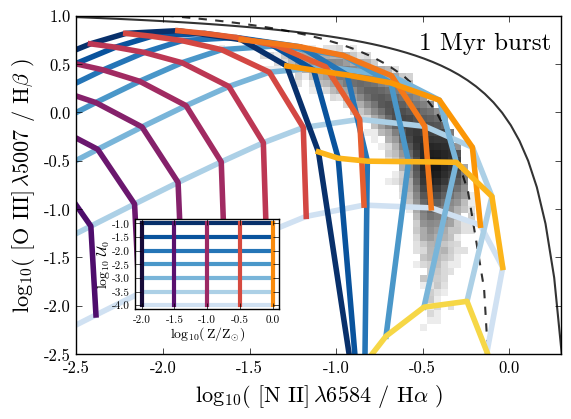

In [55]:
# data
sxname = 'logNHa'
syname = 'log_OIII_Hb'
xlim=[-1.7, 0.1]
ylim=[-2.4, 1.2]
xlab=r'$\log_{10}$( [N II]$\,\lambda$6584 / H$\alpha$ )'
ylab=r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )'
#### plotting
fig, ax = plt.subplots(1, figsize=(6.0,4.5))


plot_2Dhist(sample[sxname], sample[syname], ranges=[[-2.0,0.0], ylim], ax=ax,
            cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
# add lines
NII = np.linspace(-4.5, 0.04)
OIII = 0.61/(NII - 0.05) + 1.3
ax.plot(NII, OIII, '--', color='k', lw=1.5, alpha=0.8)
NII = np.linspace(-4.5, 0.46, 100)
OIII = 0.61/(NII - 0.47) + 1.19
ax.plot(NII, OIII, color='k', lw=1.5, alpha=0.8)

# add models
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
### D13 abundances
age=1.e6
xname, yname='log_NIIb_Ha','log_OIIIb_Hb'
altBPT(d00, ax=fig.axes[0], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5))#,
       #**return_cdict(0.2))

ax.set_xlim(-2.5, 0.3)
ax.set_ylim(-2.5, 1.0)
fig.subplots_adjust(hspace=0, wspace=0)
ax.set_xlabel(xlab, size=16)
ax.set_ylabel(ylab, size=16)
fig.tight_layout()
make_inset(axlims=[.25, .28, .24, .20], lw=3, pad=0)
ax.annotate(r'1 Myr burst',
            xy=(0.98, 0.95), fontsize=18,
            xycoords='axes fraction', ha='right', va='top')
fig.savefig('/astro/users/ebyler/Desktop/BPT.png')
#fig.savefig('../figs/f25.png')

# Fig.24: BPT comp

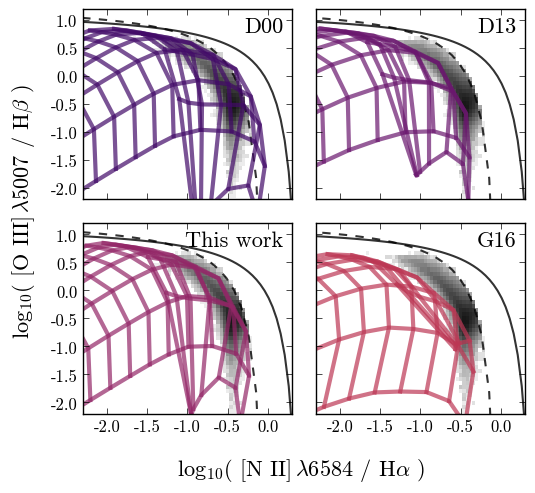

In [56]:
# data
sxname = 'logNHa'
syname = 'log_OIII_Hb'
xlim=[-1.7, 0.1]
ylim=[-2.4, 1.2]
xlab=r'$\log_{10}$( [N II]$\,\lambda$6584 / H$\alpha$ )'
ylab=r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )'
#### plotting
fig, axes = plt.subplots(2,2, figsize=(5.5,5), sharex='all', sharey='all')

for ax in fig.axes:
    plot_2Dhist(sample[sxname], sample[syname], ranges=[[-2.0,0.0], ylim], ax=ax,
                cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
    # add lines
    NII = np.linspace(-4.5, 0.04)
    OIII = 0.61/(NII - 0.05) + 1.3
    ax.plot(NII, OIII, '--', color='k', lw=1.5, alpha=0.8)
    NII = np.linspace(-4.5, 0.46, 100)
    OIII = 0.61/(NII - 0.47) + 1.19
    ax.plot(NII, OIII, color='k', lw=1.5, alpha=0.8)

# add models
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
### D13 abundances
age=1.e6
xname, yname='log_NIIb_Ha','log_OIIIb_Hb'
altBPT(d00, ax=fig.axes[0], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.2))
altBPT(d13, ax=fig.axes[1], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.3))
altBPT(uvb, ax=fig.axes[2], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.4))
altBPT(gut, ax=fig.axes[3], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.5))

for lab,ax in zip(['D00', 'D13', 'This work', 'G16'], fig.axes):
    ax.annotate(lab, xy=(0.96, 0.96),
                xycoords='axes fraction',
                ha='right', va='top', size=16)
ax.set_xlim(-2.3, 0.3)
ax.set_ylim(-2.2, 1.2)
fig.subplots_adjust(hspace=0, wspace=0)
fig.text(0.5+0.05, 0.02, xlab, ha='center', size=16)
fig.text(0.02, 0.5+0.05, ylab, va='center', rotation='vertical', size=16)
fig.tight_layout(rect=[0.05,0.05, 1, 1])
fig.savefig('../figs/f24.pdf')
fig.savefig('../figs/f24.png')

# Fig.25

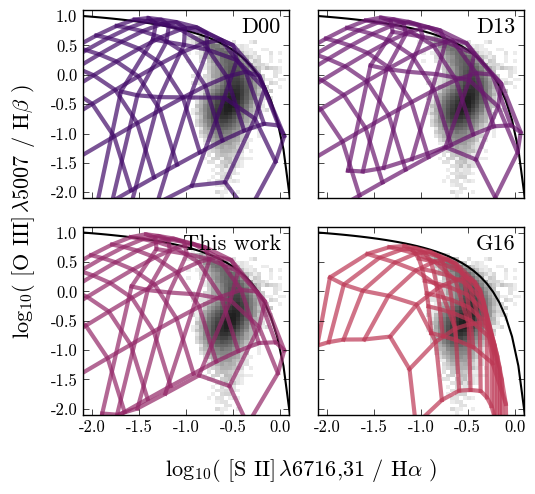

In [57]:
sxname = 'log_SII_Ha' #SII Ha
syname = 'log_OIII_Hb' #Oiiiha
ylim= [-2.1, 1.1]
xlim=[-2.1, 0.1]
ratio='SII'
age = 1.0e6
xlab = r'$\log_{10}$( [S II]$\,\lambda$6716,31 / H$\alpha$ )'
ylab = r'$\log_{10}$( [O III]$\,\lambda$5007 / H$\beta$ )'
xname, yname = sxname, syname


#### plotting
fig, axes = plt.subplots(2,2, figsize=(5.5,5), sharex='all', sharey='all')

for ax in fig.axes:
    plot_2Dhist(sample[sxname], sample[syname], ranges=[xlim, ylim], ax=ax,
                cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
    # add lines
    SII = np.linspace(-3.0, 0.31)
    OIII = 0.72/(SII - 0.32) + 1.3
    ax.plot(SII, OIII, color='k', lw=1.5, alpha=1.0)

# add models
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
### D13 abundances
altBPT(d00, ax=fig.axes[0], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.2))
altBPT(d13, ax=fig.axes[1], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.3))
altBPT(uvb, ax=fig.axes[2], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.4))
altBPT(gut, ax=fig.axes[3], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.5))

for lab,ax in zip(['D00', 'D13', 'This work', 'G16'], fig.axes):
    ax.annotate(lab, xy=(0.96, 0.96),
                xycoords='axes fraction',
                ha='right', va='top', size=16)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.subplots_adjust(hspace=0, wspace=0)
fig.text(0.5+0.05, 0.02, xlab, ha='center', size=16)
fig.text(0.02, 0.5+0.05, ylab, va='center', rotation='vertical', size=16)
fig.tight_layout(rect=[0.05,0.05, 1, 1])
fig.savefig('../figs/f25.pdf')
fig.savefig('../figs/f25.png')

# Fig.26

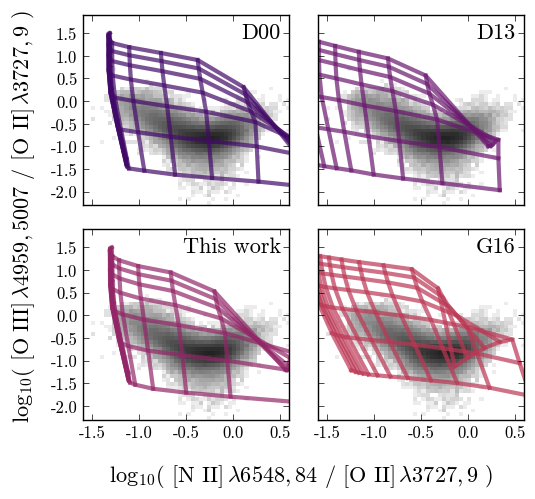

In [58]:
sxname = 'NII/OII'
syname = 'OIII/OII'
ylim= [-2.3, 1.9]
xlim=[-1.6, 0.6]
ratio='OII'
age = 1.0e6
xlab = r'$\log_{10}$( [N II]$\,\lambda6548,84$ / [O II]$\,\lambda3727,9$ )'
ylab = r'$\log_{10}$( [O$\;$III]$\,\lambda4959,5007$ / [O II]$\,\lambda3727,9$ )'
xname, yname = 'log_NII_OII', 'log_OIII_OII'
#### plotting
fig, axes = plt.subplots(2,2, figsize=(5.5,5), sharex='all', sharey='all')

for ax in fig.axes:
    plot_2Dhist(sample[sxname], sample[syname], ranges=[xlim, ylim], ax=ax,
                cmap=plt.cm.binary, vmax=1.e4, plot_cb=False)
    # add lines

# add models
def return_cdict(n, cname='inferno', lw=3, alpha=0.7):
    cdict = dict(xcname=cname, ycname=cname,
                 lw=lw, xv=(n,n), yv=(n,n), alpha=alpha)
    return cdict
### D13 abundances
altBPT(d00, ax=fig.axes[0], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.2))
altBPT(d13, ax=fig.axes[1], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.3))
altBPT(uvb, ax=fig.axes[2], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.4))
altBPT(gut, ax=fig.axes[3], age=age, override_cmap=True,
       xname=xname, yname=yname, #xlim=(), ylim=(),
       xclims=(-4.0, -1.0),
       yclims=(-2.5,0.5),
       **return_cdict(0.5))

for lab,ax in zip(['D00', 'D13', 'This work', 'G16'], fig.axes):
    ax.annotate(lab, xy=(0.96, 0.96),
                xycoords='axes fraction',
                ha='right', va='top', size=16)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
fig.subplots_adjust(hspace=0, wspace=0)
fig.text(0.5+0.05, 0.02, xlab, ha='center', size=16)
fig.text(0.02, 0.5+0.05, ylab, va='center', rotation='vertical', size=16)
fig.tight_layout(rect=[0.05,0.05, 1, 1])
fig.savefig('../figs/f26.pdf')
fig.savefig('../figs/f26.png')

In [59]:
JWST = dict(G140=(0.97,1.89),
            G235=(1.66,3.17),
            G395=(2.87,5.27))
def return_redshift(lam, filt='G140'):
    mlam_i, mlam_f = JWST[filt]
    lam_i, lam_f = mlam_i*1.e4, mlam_f*1.e4
    z_i, z_f = (lam_i/lam)-1.0, (lam_f/lam)-1.0
    return (float('{0:.1f}'.format(z_i)), float('{0:.1f}'.format(z_f)))

def return_lum(zau, line, age=1.e6, logU=-2.0, logZ=-0.5):
    ind, = np.where((zau.age == age) & (zau.logU == logU) & (zau.logZ == logZ))
    lum = zau.__getattribute__(line)[int(ind)]
    return lum

In [60]:
linefile='/astro/users/ebyler/research/uvem/data/ZAU_CSFR_ext_b_lum.lines'
zau = modObj(linefile)
##
uvdat = np.genfromtxt('/astro/users/ebyler/research/uvem/local_emLines.dat', delimiter='\t', dtype=None)

ulines = []
ulined = {}
i = 0
k = 0
m = 0
for u in uvdat:
        oname = u[0].replace('[', '').replace(']', '').replace('-', '').replace('$', '').replace('\\','_')
        if oname[0:2] not in ['HI', 'Br', 'Ly', 'Pa', 'Ba', 'PI', 'P5', 'P6', 'P7', 'P8', 'H5','H6','H7','H8', 'Pf', 'Hu', 'H_']:
            float_lambda = float(u[1])
            if (float_lambda < 3900.0) & (float_lambda > 1220.):
                i += 1
                wl = int(u[1])
                lam = u[1]
                dname = '{}_{}'.format(oname, wl)
                if dname in ulined.keys():
                    suff = '{0:.2f}'.format(lam)
                    dname = '{}_{}'.format(oname, suff.replace('.', '_'))
                ulines.append((dname, lam))
                ulined[dname] = lam
            else:
                k+=1
        else:
            m+=1

print i, k, m, uvdat.shape
print i+k+m
zau.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    line_arr = zau.__getattribute__(line)
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)

57 29 2 (88,)
88


In [61]:
zau.add_lines(ulined)
for line in ulined.keys():
    nkey = 'log_'+line+'_Hb'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.Hb)
    line_arr = np.log10(zau.__getattribute__(line))
    zau.__setattr__(nkey, nkey_arr)
    zau.__setattr__(line, line_arr)
for line in ulined.keys():
    nkey = 'log_'+line+'_He'
    nkey_arr = np.log10(zau.__getattribute__(line)/zau.HeI_3448)
    zau.__setattr__(nkey, nkey_arr)

In [62]:
plt_lines = {'OII_3729':r'[O II]$\;\lambda$3729',
             'CIII_1906':'[C III]$\;\lambda$1907',
             'OIII_1666':'O III]$\;\lambda$1666',
             'HeI_3820':'He I$\;\lambda$3820',
             #'MgII_2796':'Mg II]$\;\lambda$2796',
             'CII_2326': 'C II]$\;\lambda$2326',
             'CIV_1548': 'C IV$\;\lambda$1548',
             'NeIII_3869':'[Ne III]$\;\lambda$3869',
             'HeI_3188':'He I$\;\lambda$3188',
             'HeI_2945':'He I$\;\lambda$2945',
             'OII_2471':'[O II]$\;\lambda$2471',
             'FeII_2400':'Fe II$\;\lambda$2400',
             'HeII_1640':'He II$\;\lambda$1640',
             'SIII_1720':'S III$\;\lambda$1720',
             'SiIII_1883':'Si III]$\;\lambda$1883',
             'NIII_1752':'N III]$\;\lambda$1752',
             'NII_2142':'N II]$\;\lambda$2142'}
g_ratio_names =  ['log_OIII_1666_CIII_1906', 'log_OIII_2321_CII_2326', 'log_OII_3729_NeIII_3869', 'log_SIII_1720_CIII_1906', 'log_SIII_1720_OIII_1666', 'log_SiII_1263_CII_1335', 'log_NIII_1752_OIII_1666', 'log_SiIII_1883_CIII_1906', 'log_SIII_1720_CIII_1907', 'log_SiIII_1883_NIII_1752', 'log_AlII_2661_MgII_2796']
g_ratio_labels =  ['log[ OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 ]', 'log[ OIII$\\;\\lambda$2322 / CII$\\;\\lambda$2326 ]', 'log[ OII$\\;\\lambda$3730 / NeIII$\\;\\lambda$3870 ]', 'log[ SIII$\\;\\lambda$1720 / CIII$\\;\\lambda$1907 ]', 'log[ SIII$\\;\\lambda$1720 / OIII$\\;\\lambda$1666 ]', 'log[ SiII$\\;\\lambda$1263 / CII$\\;\\lambda$1335 ]', 'log[ NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 ]', 'log[ SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1906 ]', 'log[ SIII$\\;\\lambda$1720 / CIII$\\;\\lambda$1907 ]', 'log[ SiIII$\\;\\lambda$1883 / NIII$\\;\\lambda$1752 ]', 'log[ AlII$\\;\\lambda$2661 / MgII$\\;\\lambda$2796]']
g_ratio_lines =  [('OIII_1666', 'CIII_1906'),
                  ('OIII_2321', 'CII_2326'),
                  ('OII_3729', 'NeIII_3869'),
                  ('SIII_1720', 'CIII_1906'),
                  ('SIII_1720', 'OIII_1666'),
                  ('SiII_1263', 'CII_1335'),
                  ('NIII_1752', 'OIII_1666'),
                  ('SiIII_1883', 'CIII_1906'),
                  ('SIII_1720', 'CIII_1906'),
                  ('SiIII_1883', 'NIII_1752'),
                  ('AlII_2661', 'MgII_2796')]


g_ratio_names =  ['log_CIV_1548_OIII_1666',
                  'log_OIII_1666_CIII_1906',
                  'log_OIII_2321_CII_2326',
                  'log_OII_3729_NeIII_3869',
                  'log_OIII_2322_MgII_2796',
                  'log_CII_2326_SiIII_1883',
                  'log_SiII_1263_CII_1335',
                  'log_NIII_1752_OIII_1666',
                  'log_SiIII_1883_CIII_1906']
g_ratio_labels =  ['log(  CIV$\\;\\lambda$1548 / OIII$\\;\\lambda$1666 )',
                   'log( OIII$\\;\\lambda$1666 / CIII$\\;\\lambda$1907 )',
                   'log( OIII$\\;\\lambda$2322 / CII$\\;\\lambda$2326 )',
                   'log( OII$\\;\\lambda$3730 / NeIII$\\;\\lambda$3870 )',
                   'log( OIII$\\;\\lambda$2322 / MgII$\\;\\lambda$2796 )',
                   'log( CII$\\;\\lambda$2326 / SiIII$\\;\\lambda$1883 )',
                   'log( SiII$\\;\\lambda$1263 / CII$\\;\\lambda$1335 )',
                   'log( NIII$\\;\\lambda$1752 / OIII$\\;\\lambda$1666 )', 
                   'log( SiIII$\\;\\lambda$1883 / CIII$\\;\\lambda$1906 )']
g_ratio_lines =  [('CIV_1548', 'OIII_1666'), ('OIII_1666', 'CIII_1906'), ('OIII_2321', 'CII_2326'), ('OII_3729', 'NeIII_3869'), ('OIII_2321', 'MgII_2796'), ('CII_2326', 'SiIII_1883'), ('SiII_1263', 'CII_1335'), ('NIII_1752', 'OIII_1666'), ('SiIII_1883', 'CIII_1906')]

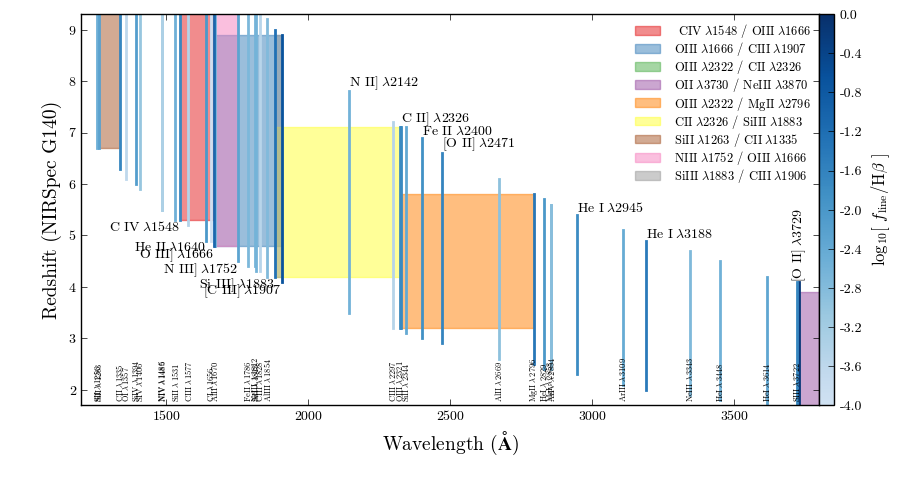

In [116]:
lumlim=-4.
arr = np.linspace(lumlim, -0.0)
sM, cNorm = getColors(arr, cname='Blues', minv=0.2, maxv=1.0, return_cNorm=True)

#fig, ax = plt.subplots(1, figsize=(8.,4.5))
fig, (ax, cax) = plt.subplots(1,2, figsize=(9.0,5.0), gridspec_kw={"width_ratios":[1, 0.02]})
larr = []
for name, line in ulined.items():
    zrange = return_redshift(line)
    lum = return_lum(zau, 'log_'+name+'_Hb')
    if lum >= lumlim:
        larr.append(lum)
        color = sM.to_rgba(lum)
        ax.plot((line, line), zrange, color=color, lw=2)
        rotation=0
        #ax.plot(zrange, (line, line), color=color, lw=2)
        if name in plt_lines.keys():
            if zrange[0] > 3.5:
                ha='right'
                va='top'
                xy = (line, zrange[0])
                #xy = (zrange[0], line)   
            else:
                ha='left'
                va='bottom'
                xy=(line, zrange[1])
                #xy = (zrange[1], line)
            if line > 3500.:
                rotation = 90
                va='bottom'
                ha='center'
            ax.annotate(plt_lines[name],
                        xy=xy,
                        xytext=(0,0),
                        textcoords='offset points', va=va, ha=ha, size=10, rotation=rotation)
        else:
            if (line >= 1200.) & (line <= 3800.):
                ax.annotate(name.replace('_',r'$\;\lambda\,$'),
                            xy=(line, 0.01), xycoords=('data', 'axes fraction'),
                            xytext=(0,0),
                            textcoords='offset points', va='bottom', ha='center', size=6, rotation=90)
        #if (line < 3800.) & (line > 1300.) & (zrange[0] < 8.) & (lum > -1.3):
        #if (line < 4000.) & (line > 2500.) & (lum > -3.8):
        #    print name, unames[name][0], line
        
        #    ax.annotate('{}'.format(unames[name][0]),
        #                    xy=(zrange[1], line),
        #                    xytext=(0,0),
        #                    textcoords='offset points', va='center', ha='left')
colors = nColors(len(g_ratio_names), cname='Set1', minv=0.0, maxv=1.0)
#sMr = getColors(np.arange(0,10,1), cname='Set2', minv=0.0, maxv=1.0)
#colors = [sMr.to_rgba(i+0.5) for i in range(10)]
for ratio_name, ratio_label, ratio_line, color in zip(g_ratio_names, g_ratio_labels, g_ratio_lines, colors):
    l1 = np.float(ratio_line[0].split('_')[-1])
    l2 = np.float(ratio_line[1].split('_')[-1])
    z1 = return_redshift(l1)
    z2 = return_redshift(l2)
    zrange = (np.max([z1[0], z2[0]]), np.min([z1[1], z2[1]]))
    line = np.mean([l1,l2])
    #color = sMr.to_rgba(zrange[0])
    if zrange[1] > 7.0:
        ha='right'
        xy = (line, np.mean(zrange))
        #xy = (np.mean(zrange), line)
    else:
        ha='left'
        xy = (line, np.mean(zrange))
        #xy = (np.mean(zrange), line)
    ax.fill_between(np.array([l1, l2]), zrange[0], zrange[1], color=color, alpha=0.5, zorder=0,
                    label=ratio_label.strip('log(')[0:-1])
    #ax.annotate(ratio_label.strip('log(')[0:-1],
    #            xy=xy,
    #            xytext=(0,0),
    #            textcoords='offset points', va='center', ha='left', size=10, rotation=90)
ax.legend(frameon=False, fontsize=9, labelspacing=0.01, borderpad=0.1)
##
sM.set_array(np.array(larr))
cb = fig.colorbar(sM, cax=cax, cmap=sM.cmap, norm=cNorm)
cb.set_label(r'$\log_{10}$[ $f_{\mathrm{line}}$/H$\beta$ ]', size=12)
cb.ax.tick_params(labelsize=10) 

ax.set_ylabel('Redshift (NIRSpec G140)', size=14)
ax.set_xlabel(r'Wavelength ($\mathrm{\AA}$)', size=14)
ax.set_ylim(1.7,9.3)
ax.set_xlim(1200., 3800.)
plt.setp(ax.get_xticklabels(), fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

fig.tight_layout()
fig.subplots_adjust(wspace=0.0)
fig.savefig('../figs/f29.pdf')
fig.savefig('../figs/f29.png')